<a href="https://colab.research.google.com/github/lustea0201/Underdogs/blob/master/Final_project/Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the training dataset


In [1]:
!rm -rf data.zip


import zipfile

from google.colab import drive
drive.mount('/content/drive/')

data = zipfile.ZipFile("/content/drive/My Drive/Super Resolution/data.zip", 'r')

data.extractall()
data.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os 
from torchvision.datasets import ImageFolder
from torchvision import transforms





In [3]:
import torch

train = []
test = []

N_train = 70 
N_test = 30 

for s in ["irregular","circle"]:
  for n in ["1","16","32","64"]: 
    X_t = ImageFolder(root = "/content/data/" + s + "_" + n + "/Low", transform = transforms.ToTensor())
    Y_t = ImageFolder(root = "/content/data/" + s + "_" + n + "/High", transform = transforms.ToTensor())
    for i in range(N_test):
      test.append([X_t[i][0], Y_t[i][0]])

    for i in range(N_test, N_train+N_test):
      train.append([X_t[i][0], Y_t[i][0]])

train_loader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=16)
test_loader = torch.utils.data.DataLoader(test, shuffle=False, batch_size=16)
X, Y = next(iter(train_loader))
print(X.shape)


torch.Size([16, 3, 512, 512])


(-0.5, 1023.5, 1023.5, -0.5)

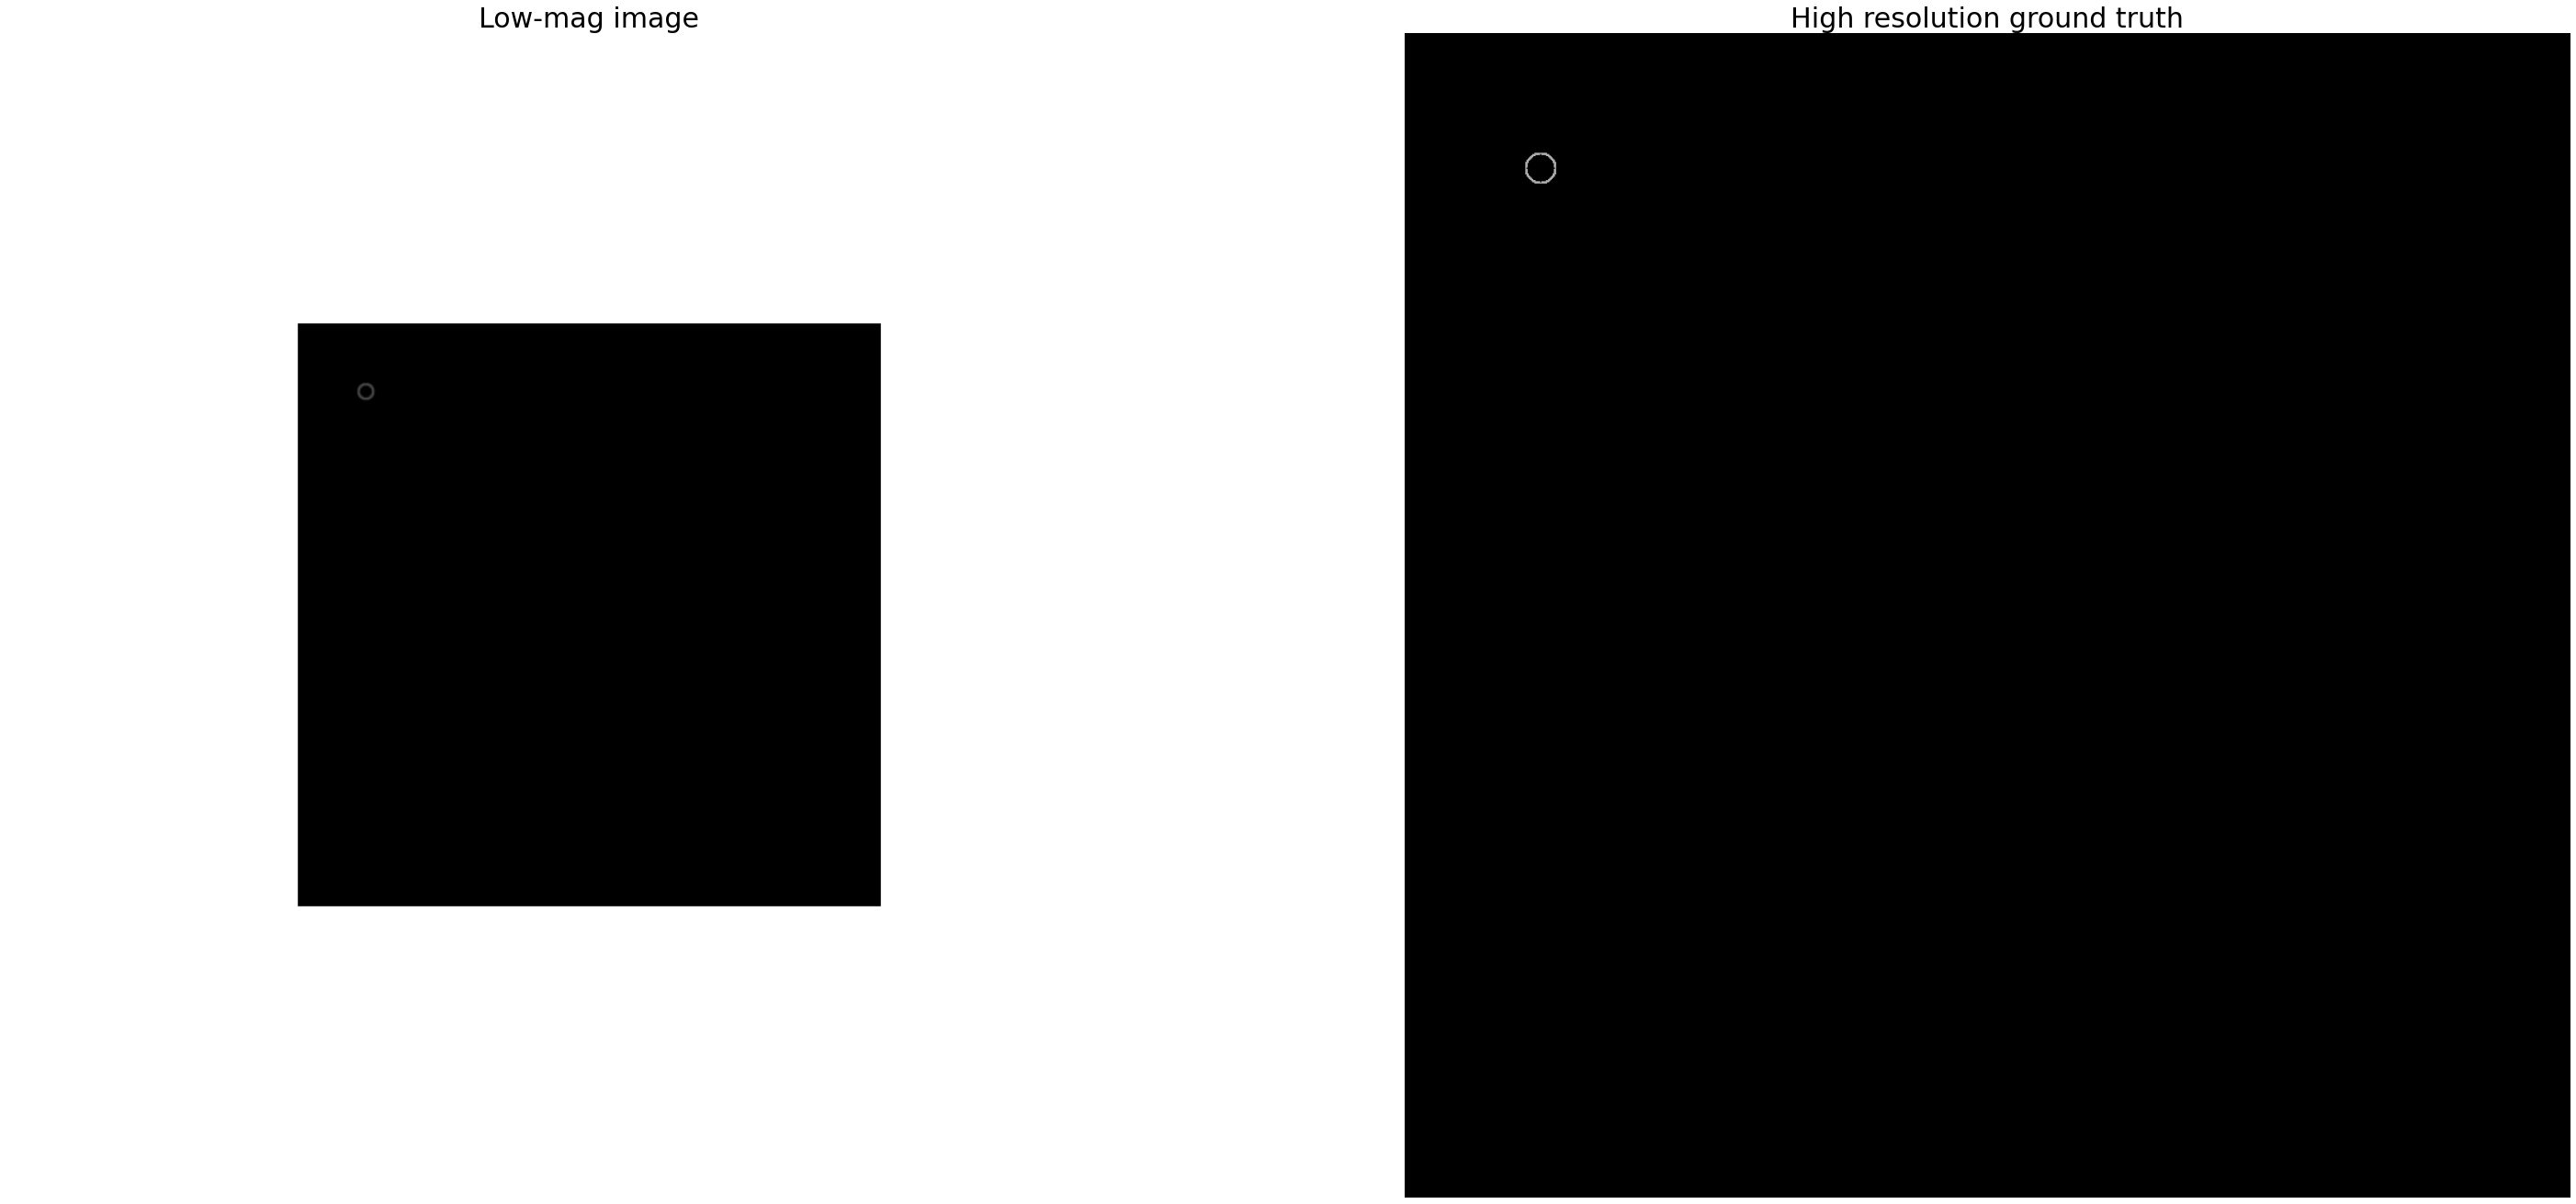

In [4]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1,2, figsize=(50,25))
im_h = Y[0].permute(1, 2, 0)
im_l = torch.ones(im_h.shape) 
height = im_h.shape[0]
width = im_h.shape[1]
im_l[height//4:height-height//4, width//4:width-width//4, :] = X[0].permute(1,2,0)


axes[0].imshow(im_l)
axes[0].set_title("Low-mag image", fontsize=30);
axes[0].axis('off')
axes[1].imshow(im_h)
axes[1].set_title("High resolution ground truth", fontsize=30);
axes[1].axis('off')


In [0]:
import torch.nn as nn
import torch.nn.init as init


class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, 3*upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        x = self.pixel_shuffle(x)
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)


class Net2(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        return x


In [0]:
import matplotlib.pyplot as plt 
import numpy as np

def compare(p,t, gen): 
  fig, axes = plt.subplots(1,2, figsize=(30,15))

  p = p.cpu().detach()
  t = t.cpu().detach()
  p = (255*p.permute(1, 2, 0)).numpy().astype(np.uint8)
  axes[0].imshow(p)
  axes[0].set_title("Prediction (generation %d)" %gen, fontsize=30);
  axes[0].axis('off')

  t = (255*t.permute(1, 2, 0)).numpy().astype(np.uint8)
  axes[1].imshow(t)
  axes[1].set_title("High resolution ground truth", fontsize=30);
  axes[1].axis('off')
  plt.show()

In [9]:
import torch.optim as optim
from math import log10



torch.manual_seed(12)

device = torch.device("cuda")

print('===> Building model')
model = Net(upscale_factor=2).to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.005)

===> Building model


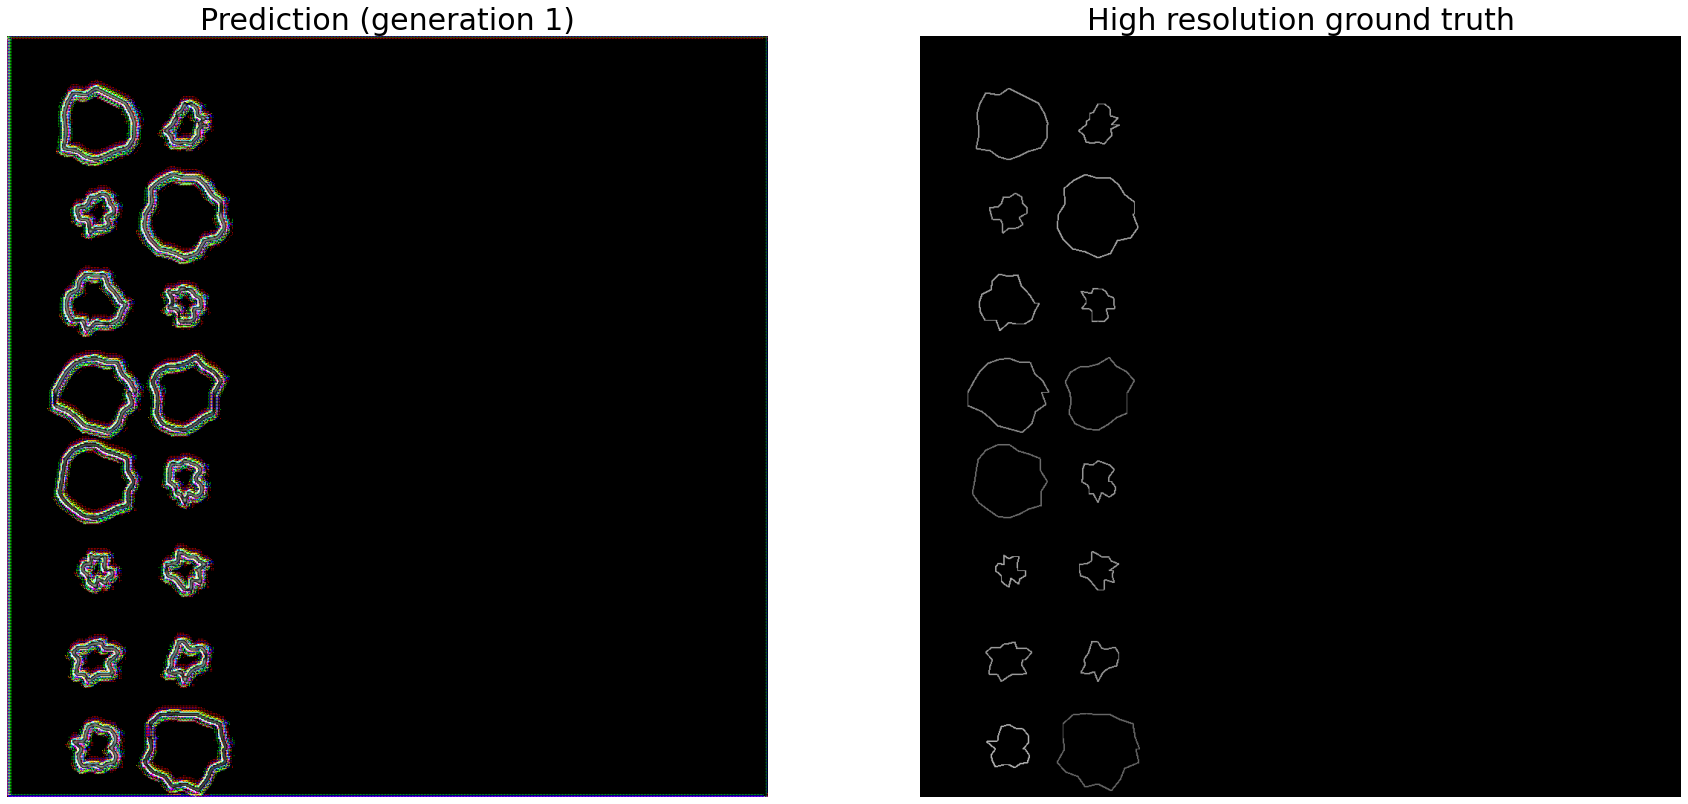

===> Epoch 1 Complete: Avg. Loss: 2.2635
===> Avg. PSNR: 32.3412 dB
===> Epoch 2 Complete: Avg. Loss: 0.7621
===> Avg. PSNR: 34.6393 dB
===> Epoch 3 Complete: Avg. Loss: 0.5075
===> Avg. PSNR: 35.9204 dB
===> Epoch 4 Complete: Avg. Loss: 0.4163
===> Avg. PSNR: 36.5134 dB
===> Epoch 5 Complete: Avg. Loss: 0.3739
===> Avg. PSNR: 36.9224 dB
===> Epoch 6 Complete: Avg. Loss: 0.3440
===> Avg. PSNR: 37.1629 dB
===> Epoch 7 Complete: Avg. Loss: 0.3261
===> Avg. PSNR: 37.4055 dB
===> Epoch 8 Complete: Avg. Loss: 0.3052
===> Avg. PSNR: 37.7688 dB
===> Epoch 9 Complete: Avg. Loss: 0.2884
===> Avg. PSNR: 38.0552 dB
===> Epoch 10 Complete: Avg. Loss: 0.2679
===> Avg. PSNR: 38.2833 dB


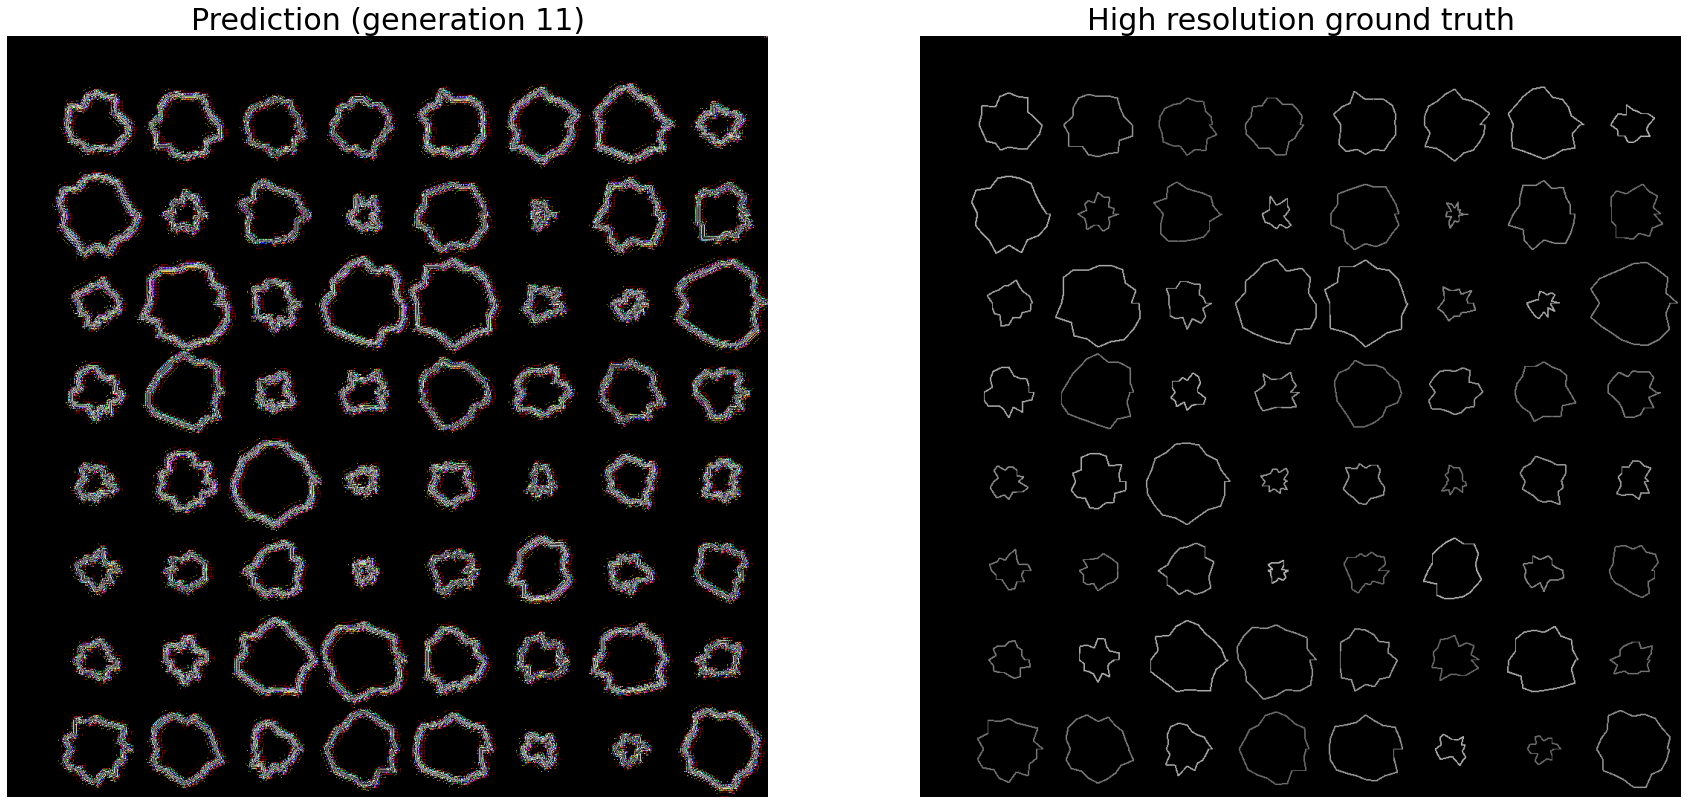

===> Epoch 11 Complete: Avg. Loss: 0.2666
===> Avg. PSNR: 38.5025 dB
===> Epoch 12 Complete: Avg. Loss: 0.2417
===> Avg. PSNR: 38.7718 dB
===> Epoch 13 Complete: Avg. Loss: 0.2447
===> Avg. PSNR: 37.8390 dB
===> Epoch 14 Complete: Avg. Loss: 0.2560
===> Avg. PSNR: 38.6803 dB
===> Epoch 15 Complete: Avg. Loss: 0.2367
===> Avg. PSNR: 39.2381 dB
===> Epoch 16 Complete: Avg. Loss: 0.2076
===> Avg. PSNR: 39.4405 dB
===> Epoch 17 Complete: Avg. Loss: 0.1988
===> Avg. PSNR: 39.6494 dB
===> Epoch 18 Complete: Avg. Loss: 0.1976
===> Avg. PSNR: 39.7546 dB
===> Epoch 19 Complete: Avg. Loss: 0.1869
===> Avg. PSNR: 39.8281 dB
===> Epoch 20 Complete: Avg. Loss: 0.1778
===> Avg. PSNR: 40.1228 dB


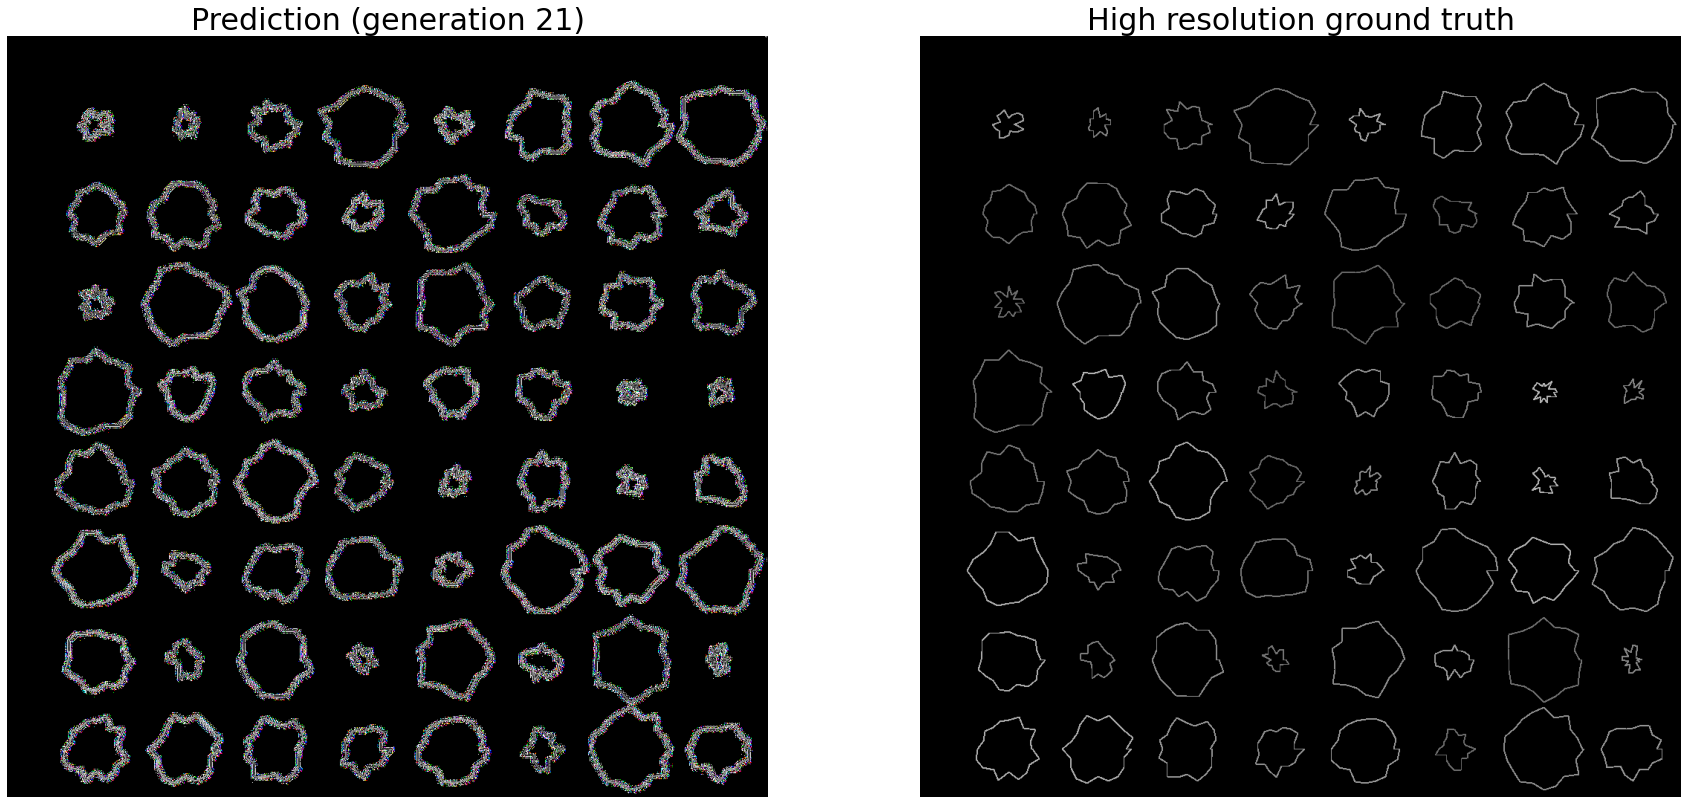

===> Epoch 21 Complete: Avg. Loss: 0.1984
===> Avg. PSNR: 40.1014 dB
===> Epoch 22 Complete: Avg. Loss: 0.1692
===> Avg. PSNR: 40.4750 dB
===> Epoch 23 Complete: Avg. Loss: 0.1595
===> Avg. PSNR: 40.6663 dB
===> Epoch 24 Complete: Avg. Loss: 0.1568
===> Avg. PSNR: 40.2492 dB
===> Epoch 25 Complete: Avg. Loss: 0.1651
===> Avg. PSNR: 40.6943 dB
===> Epoch 26 Complete: Avg. Loss: 0.1481
===> Avg. PSNR: 41.1156 dB
===> Epoch 27 Complete: Avg. Loss: 0.1396
===> Avg. PSNR: 41.2503 dB
===> Epoch 28 Complete: Avg. Loss: 0.1350
===> Avg. PSNR: 41.3485 dB
===> Epoch 29 Complete: Avg. Loss: 0.1405
===> Avg. PSNR: 41.3938 dB
===> Epoch 30 Complete: Avg. Loss: 0.1339
===> Avg. PSNR: 41.5417 dB


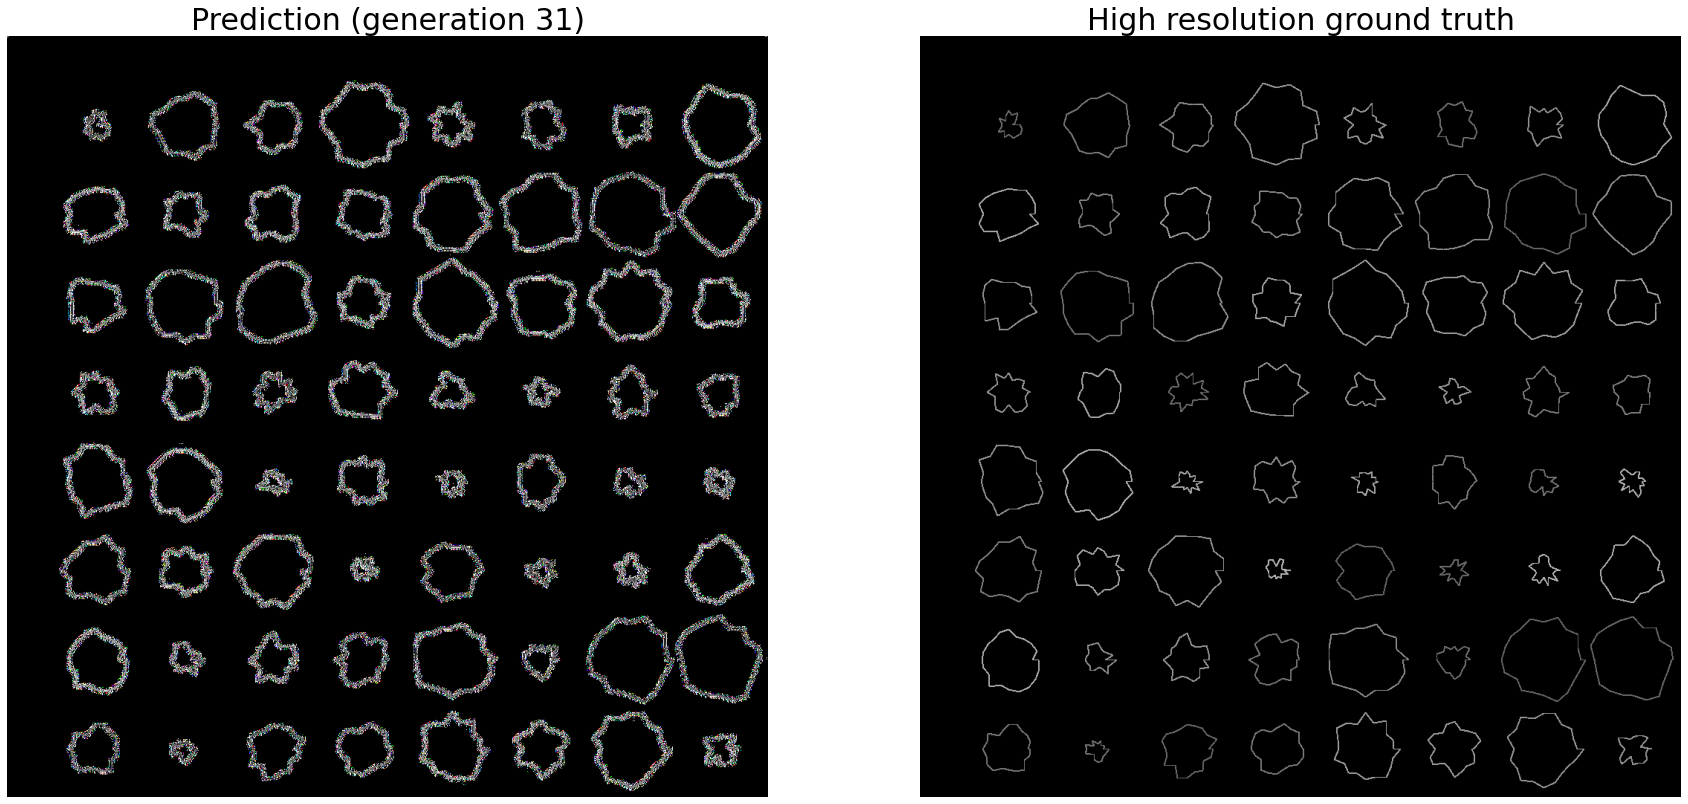

===> Epoch 31 Complete: Avg. Loss: 0.1244
===> Avg. PSNR: 41.8747 dB
===> Epoch 32 Complete: Avg. Loss: 0.1226
===> Avg. PSNR: 41.7171 dB
===> Epoch 33 Complete: Avg. Loss: 0.1283
===> Avg. PSNR: 41.8387 dB
===> Epoch 34 Complete: Avg. Loss: 0.1160
===> Avg. PSNR: 41.6502 dB
===> Epoch 35 Complete: Avg. Loss: 0.1157
===> Avg. PSNR: 42.1700 dB
===> Epoch 36 Complete: Avg. Loss: 0.1113
===> Avg. PSNR: 42.5525 dB
===> Epoch 37 Complete: Avg. Loss: 0.1037
===> Avg. PSNR: 42.6704 dB
===> Epoch 38 Complete: Avg. Loss: 0.1193
===> Avg. PSNR: 42.2042 dB
===> Epoch 39 Complete: Avg. Loss: 0.1136
===> Avg. PSNR: 42.8172 dB
===> Epoch 40 Complete: Avg. Loss: 0.0983
===> Avg. PSNR: 43.0958 dB


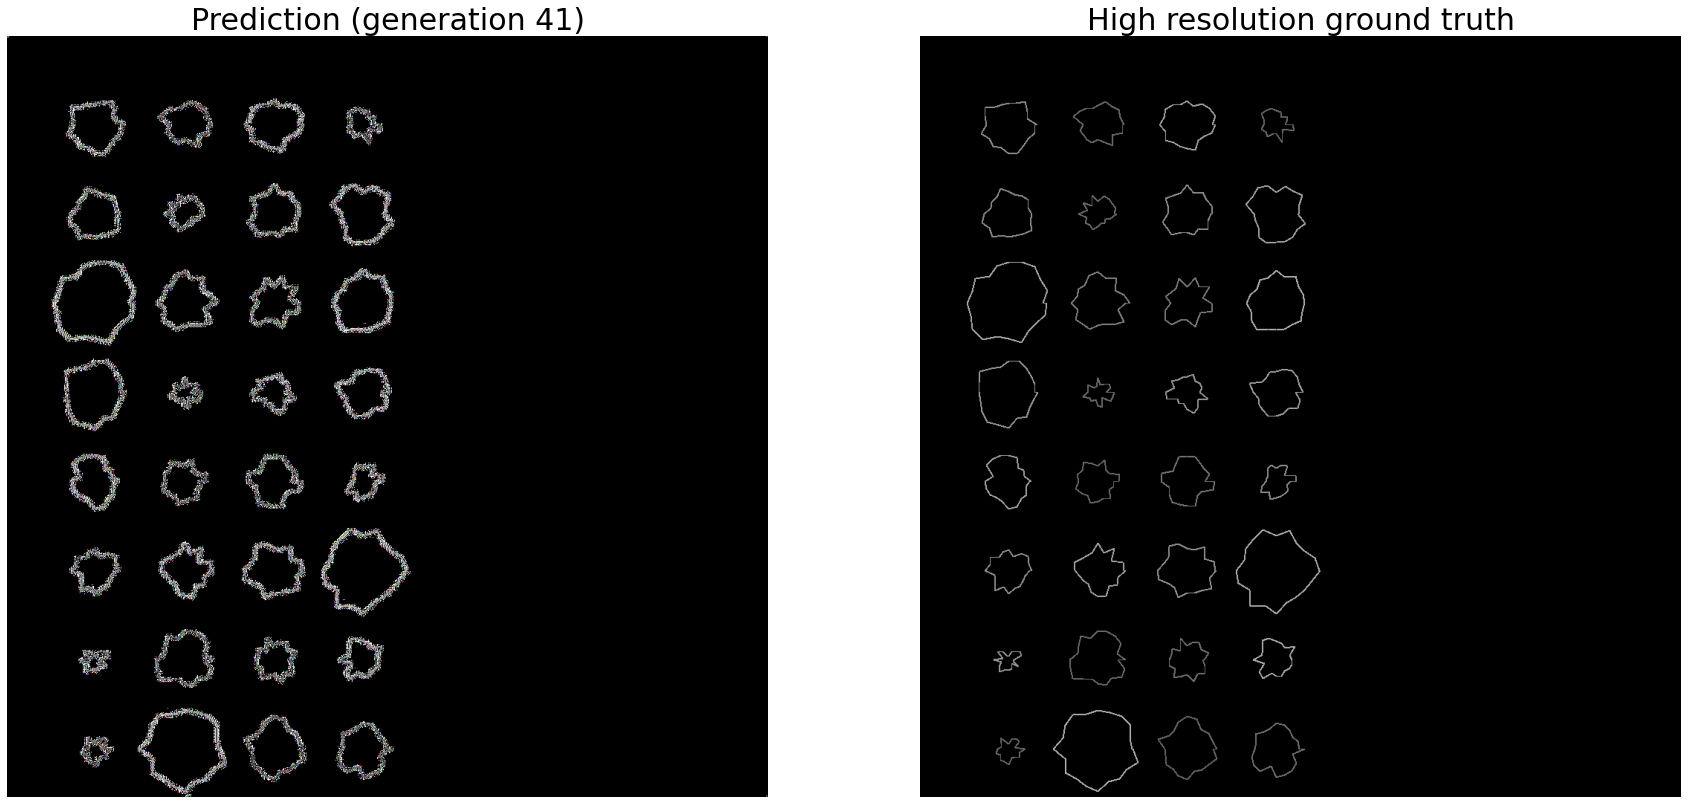

===> Epoch 41 Complete: Avg. Loss: 0.0985
===> Avg. PSNR: 43.2387 dB
===> Epoch 42 Complete: Avg. Loss: 0.0935
===> Avg. PSNR: 43.3506 dB
===> Epoch 43 Complete: Avg. Loss: 0.0891
===> Avg. PSNR: 43.3981 dB
===> Epoch 44 Complete: Avg. Loss: 0.0901
===> Avg. PSNR: 43.6330 dB
===> Epoch 45 Complete: Avg. Loss: 0.0868
===> Avg. PSNR: 43.7142 dB
===> Epoch 46 Complete: Avg. Loss: 0.0833
===> Avg. PSNR: 43.4113 dB
===> Epoch 47 Complete: Avg. Loss: 0.0829
===> Avg. PSNR: 43.2722 dB
===> Epoch 48 Complete: Avg. Loss: 0.0951
===> Avg. PSNR: 43.6973 dB
===> Epoch 49 Complete: Avg. Loss: 0.0810
===> Avg. PSNR: 43.9728 dB
===> Epoch 50 Complete: Avg. Loss: 0.0838
===> Avg. PSNR: 43.5918 dB


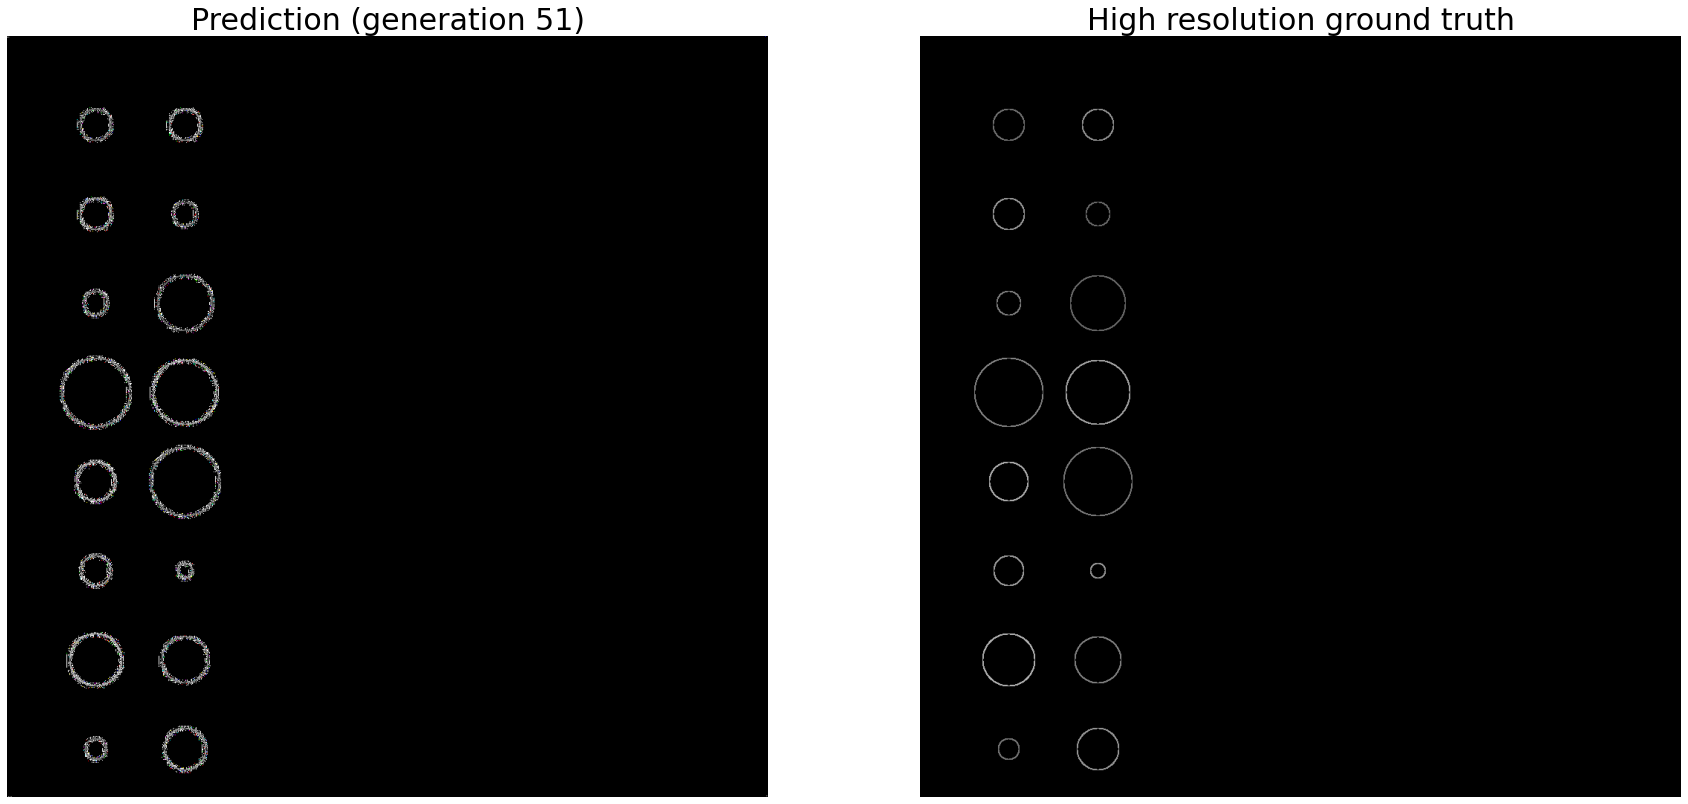

===> Epoch 51 Complete: Avg. Loss: 0.0897
===> Avg. PSNR: 43.8261 dB
===> Epoch 52 Complete: Avg. Loss: 0.0764
===> Avg. PSNR: 44.4184 dB
===> Epoch 53 Complete: Avg. Loss: 0.0723
===> Avg. PSNR: 44.5631 dB
===> Epoch 54 Complete: Avg. Loss: 0.0705
===> Avg. PSNR: 44.6407 dB
===> Epoch 55 Complete: Avg. Loss: 0.0691
===> Avg. PSNR: 44.8020 dB
===> Epoch 56 Complete: Avg. Loss: 0.0671
===> Avg. PSNR: 44.9586 dB
===> Epoch 57 Complete: Avg. Loss: 0.0674
===> Avg. PSNR: 44.6413 dB
===> Epoch 58 Complete: Avg. Loss: 0.0729
===> Avg. PSNR: 44.9984 dB
===> Epoch 59 Complete: Avg. Loss: 0.0689
===> Avg. PSNR: 45.2585 dB
===> Epoch 60 Complete: Avg. Loss: 0.0630
===> Avg. PSNR: 45.3512 dB


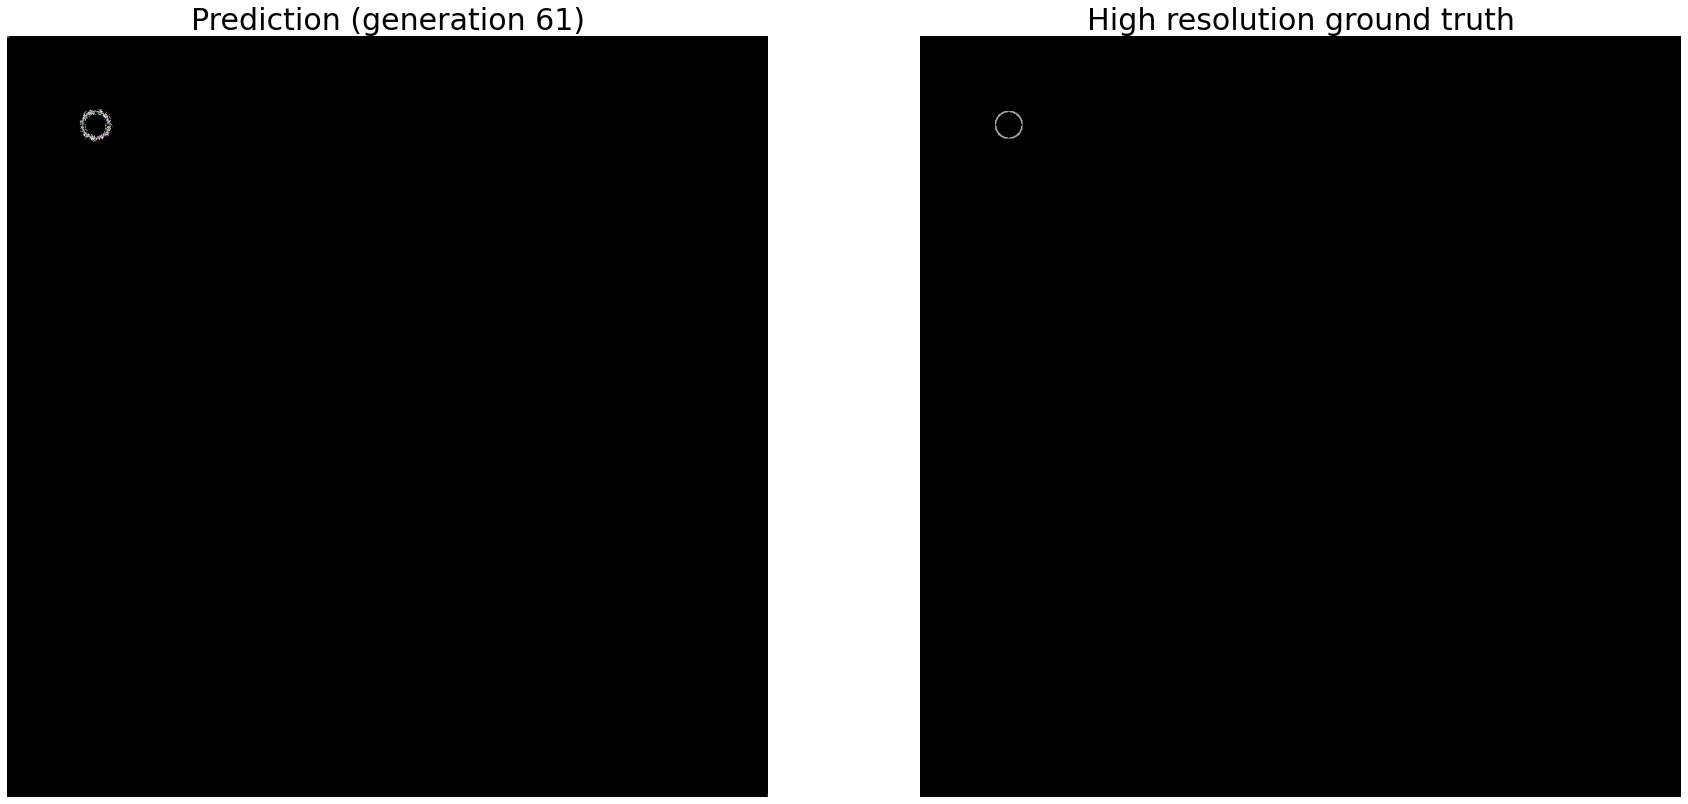

===> Epoch 61 Complete: Avg. Loss: 0.0612
===> Avg. PSNR: 45.4591 dB
===> Epoch 62 Complete: Avg. Loss: 0.0603
===> Avg. PSNR: 45.4345 dB
===> Epoch 63 Complete: Avg. Loss: 0.0787
===> Avg. PSNR: 44.3247 dB
===> Epoch 64 Complete: Avg. Loss: 0.0672
===> Avg. PSNR: 44.9505 dB
===> Epoch 65 Complete: Avg. Loss: 0.0591
===> Avg. PSNR: 45.7922 dB
===> Epoch 66 Complete: Avg. Loss: 0.0587
===> Avg. PSNR: 44.3514 dB
===> Epoch 67 Complete: Avg. Loss: 0.0674
===> Avg. PSNR: 43.4352 dB
===> Epoch 68 Complete: Avg. Loss: 0.0609
===> Avg. PSNR: 45.9127 dB
===> Epoch 69 Complete: Avg. Loss: 0.0568
===> Avg. PSNR: 45.4879 dB
===> Epoch 70 Complete: Avg. Loss: 0.0612
===> Avg. PSNR: 45.9805 dB


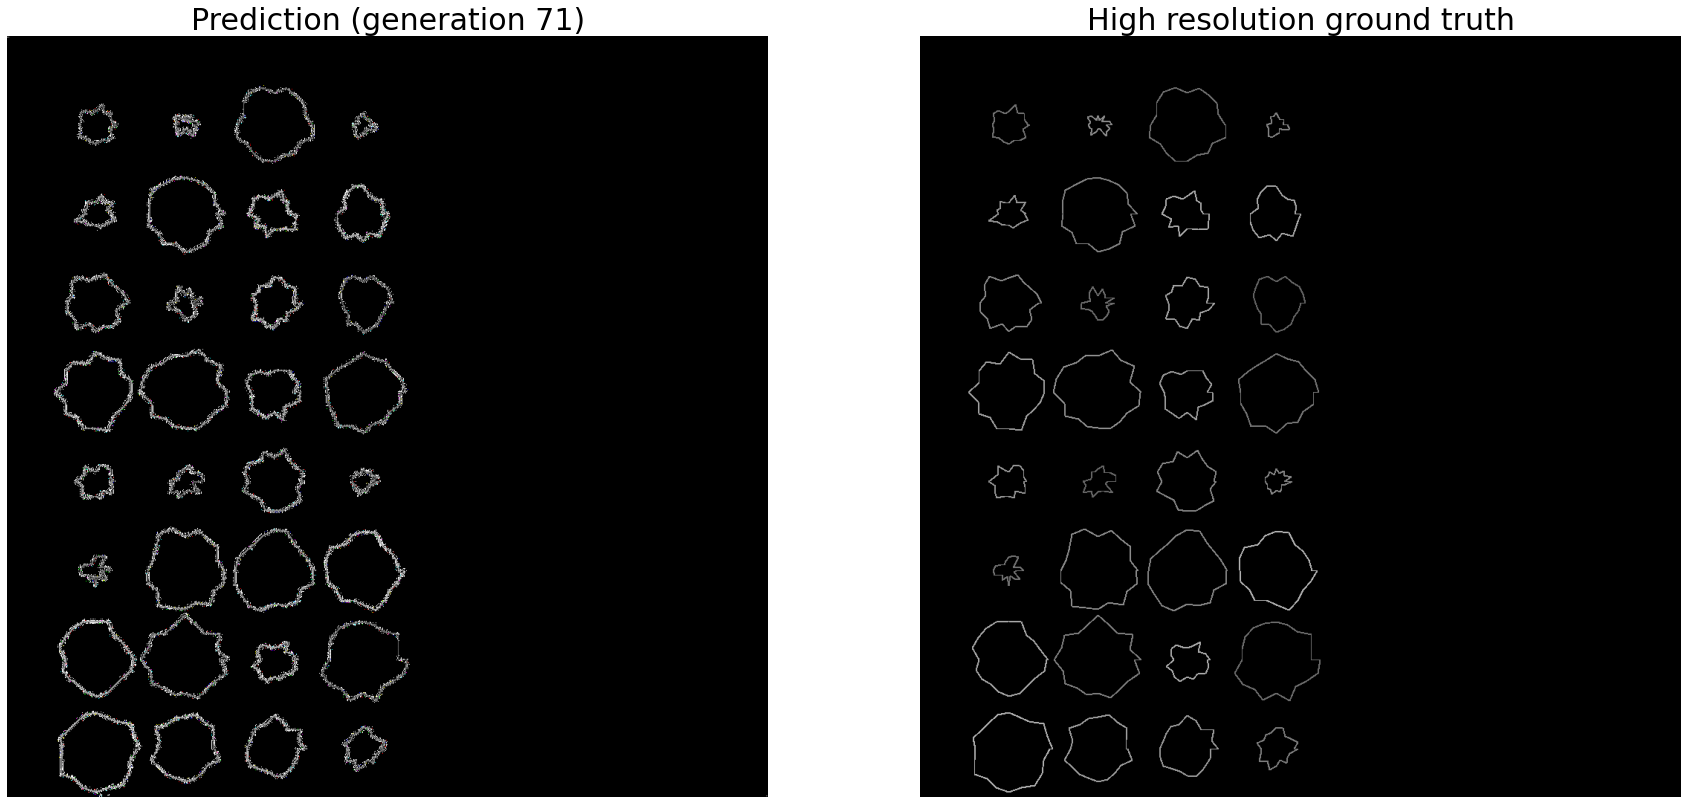

===> Epoch 71 Complete: Avg. Loss: 0.0527
===> Avg. PSNR: 46.2277 dB
===> Epoch 72 Complete: Avg. Loss: 0.0516
===> Avg. PSNR: 46.2213 dB
===> Epoch 73 Complete: Avg. Loss: 0.0507
===> Avg. PSNR: 46.2914 dB
===> Epoch 74 Complete: Avg. Loss: 0.0512
===> Avg. PSNR: 46.3066 dB
===> Epoch 75 Complete: Avg. Loss: 0.0518
===> Avg. PSNR: 45.4977 dB
===> Epoch 76 Complete: Avg. Loss: 0.0518
===> Avg. PSNR: 46.4577 dB
===> Epoch 77 Complete: Avg. Loss: 0.0533
===> Avg. PSNR: 45.1117 dB
===> Epoch 78 Complete: Avg. Loss: 0.0527
===> Avg. PSNR: 45.8469 dB
===> Epoch 79 Complete: Avg. Loss: 0.0500
===> Avg. PSNR: 46.5372 dB
===> Epoch 80 Complete: Avg. Loss: 0.0485
===> Avg. PSNR: 46.7634 dB


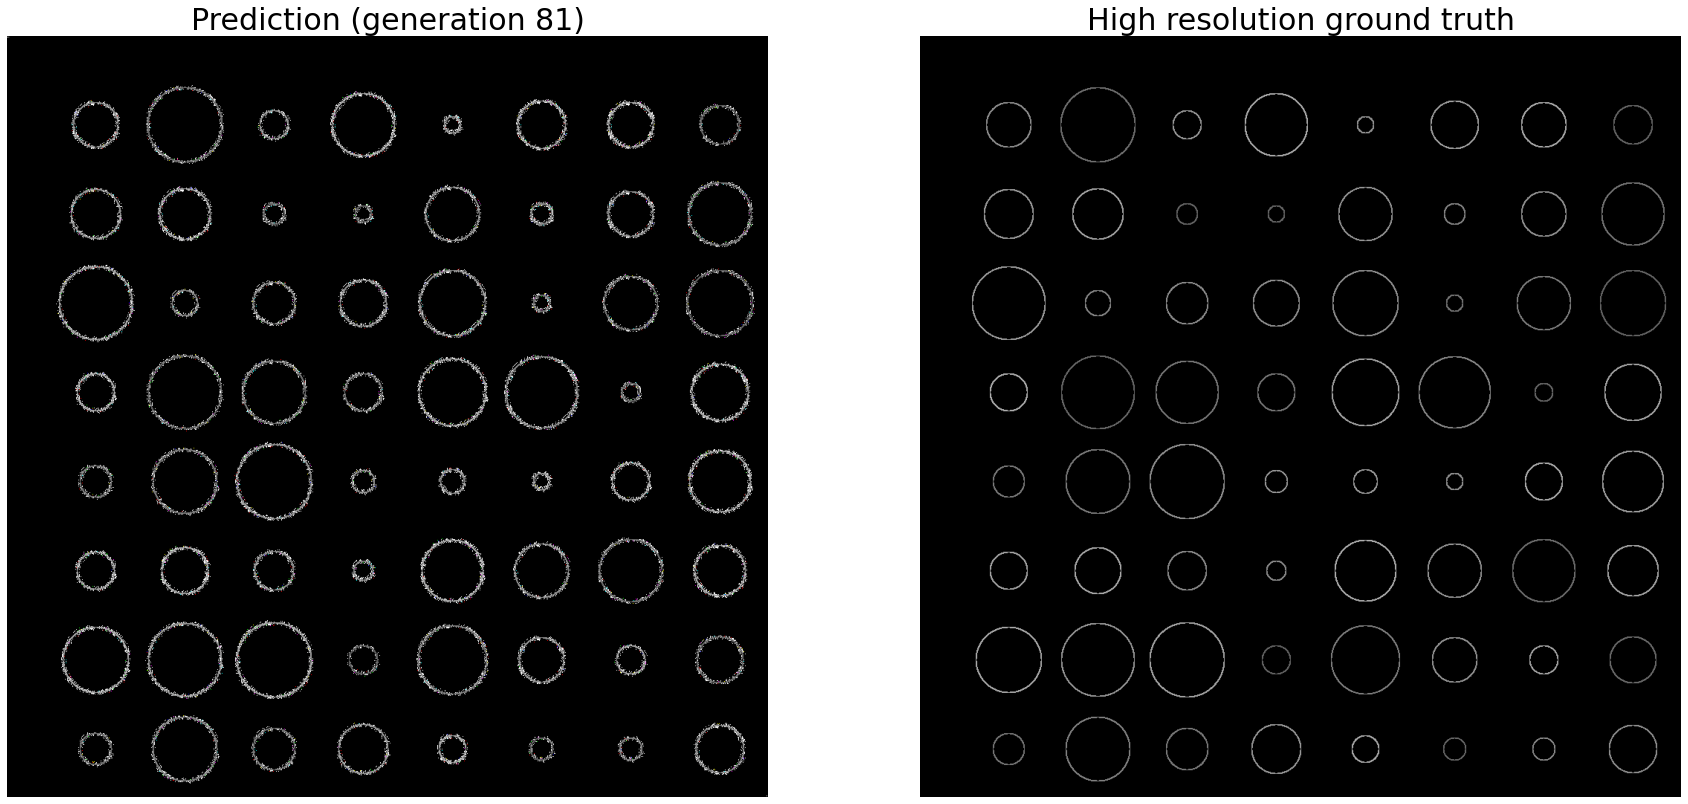

===> Epoch 81 Complete: Avg. Loss: 0.0471
===> Avg. PSNR: 46.8711 dB
===> Epoch 82 Complete: Avg. Loss: 0.0456
===> Avg. PSNR: 46.6574 dB
===> Epoch 83 Complete: Avg. Loss: 0.0456
===> Avg. PSNR: 46.8751 dB
===> Epoch 84 Complete: Avg. Loss: 0.0584
===> Avg. PSNR: 42.3321 dB
===> Epoch 85 Complete: Avg. Loss: 0.0716
===> Avg. PSNR: 46.3677 dB
===> Epoch 86 Complete: Avg. Loss: 0.0464
===> Avg. PSNR: 47.0123 dB
===> Epoch 87 Complete: Avg. Loss: 0.0436
===> Avg. PSNR: 47.0827 dB
===> Epoch 88 Complete: Avg. Loss: 0.0447
===> Avg. PSNR: 47.1283 dB
===> Epoch 89 Complete: Avg. Loss: 0.0429
===> Avg. PSNR: 47.0738 dB
===> Epoch 90 Complete: Avg. Loss: 0.0424
===> Avg. PSNR: 47.1018 dB


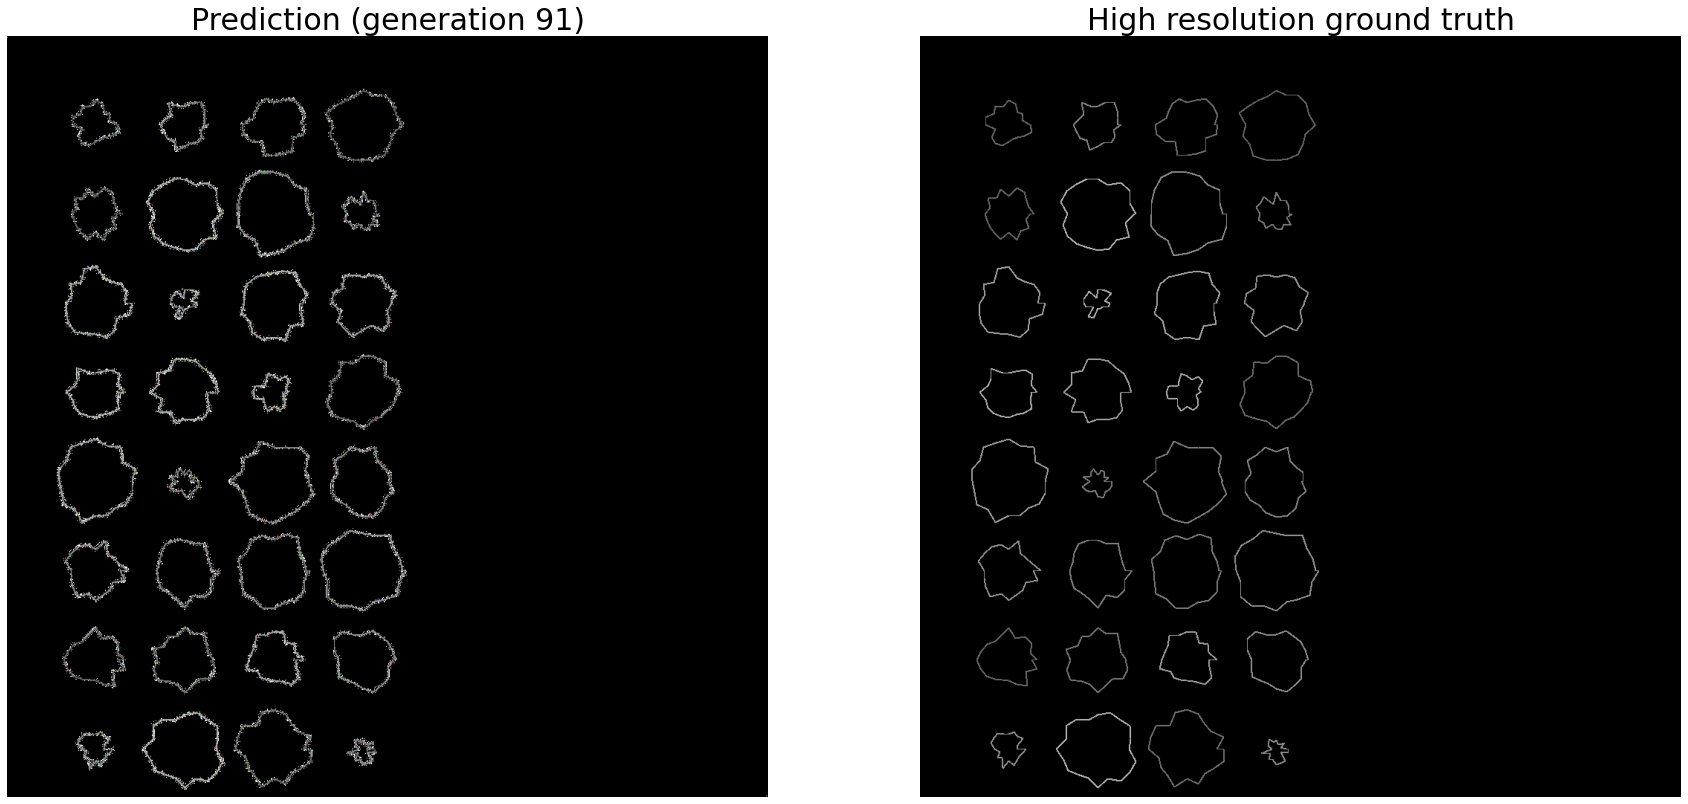

===> Epoch 91 Complete: Avg. Loss: 0.0428
===> Avg. PSNR: 46.5965 dB
===> Epoch 92 Complete: Avg. Loss: 0.0567
===> Avg. PSNR: 43.4343 dB
===> Epoch 93 Complete: Avg. Loss: 0.0517
===> Avg. PSNR: 47.1066 dB
===> Epoch 94 Complete: Avg. Loss: 0.0416
===> Avg. PSNR: 47.1697 dB
===> Epoch 95 Complete: Avg. Loss: 0.0417
===> Avg. PSNR: 47.5142 dB
===> Epoch 96 Complete: Avg. Loss: 0.0401
===> Avg. PSNR: 47.5488 dB
===> Epoch 97 Complete: Avg. Loss: 0.0395
===> Avg. PSNR: 47.6506 dB
===> Epoch 98 Complete: Avg. Loss: 0.0409
===> Avg. PSNR: 47.2506 dB
===> Epoch 99 Complete: Avg. Loss: 0.0400
===> Avg. PSNR: 46.8663 dB
===> Epoch 100 Complete: Avg. Loss: 0.0417
===> Avg. PSNR: 47.8010 dB


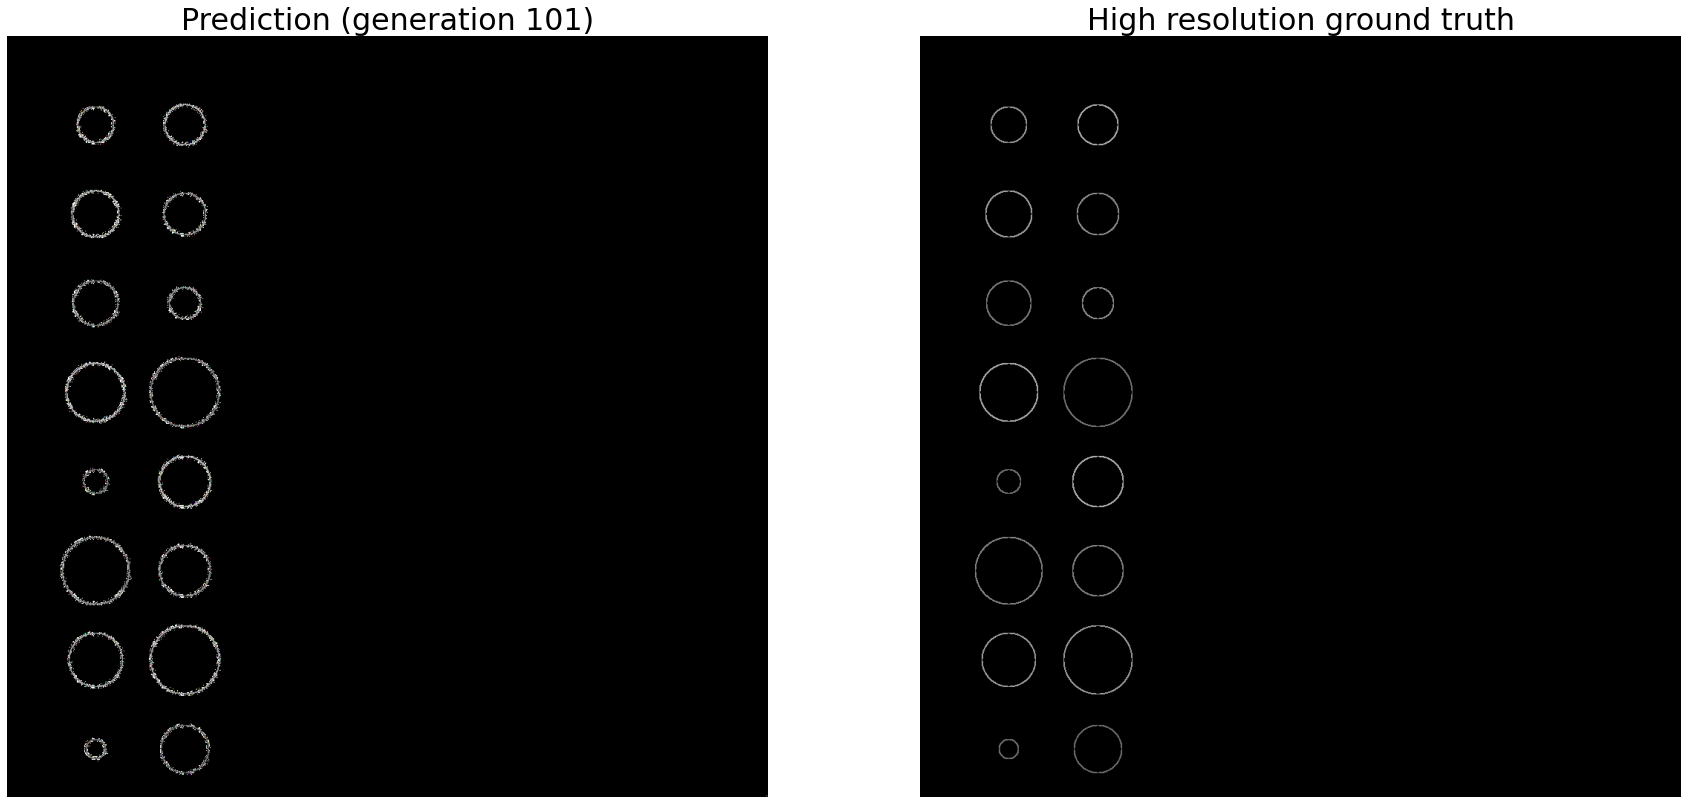

===> Epoch 101 Complete: Avg. Loss: 0.0388
===> Avg. PSNR: 47.4858 dB
===> Epoch 102 Complete: Avg. Loss: 0.0395
===> Avg. PSNR: 47.8911 dB
===> Epoch 103 Complete: Avg. Loss: 0.0387
===> Avg. PSNR: 47.1701 dB
===> Epoch 104 Complete: Avg. Loss: 0.0408
===> Avg. PSNR: 47.9515 dB
===> Epoch 105 Complete: Avg. Loss: 0.0404
===> Avg. PSNR: 45.1390 dB
===> Epoch 106 Complete: Avg. Loss: 0.0567
===> Avg. PSNR: 46.2968 dB
===> Epoch 107 Complete: Avg. Loss: 0.0437
===> Avg. PSNR: 47.8662 dB
===> Epoch 108 Complete: Avg. Loss: 0.0369
===> Avg. PSNR: 48.0888 dB
===> Epoch 109 Complete: Avg. Loss: 0.0480
===> Avg. PSNR: 40.2817 dB
===> Epoch 110 Complete: Avg. Loss: 0.0913
===> Avg. PSNR: 45.9439 dB


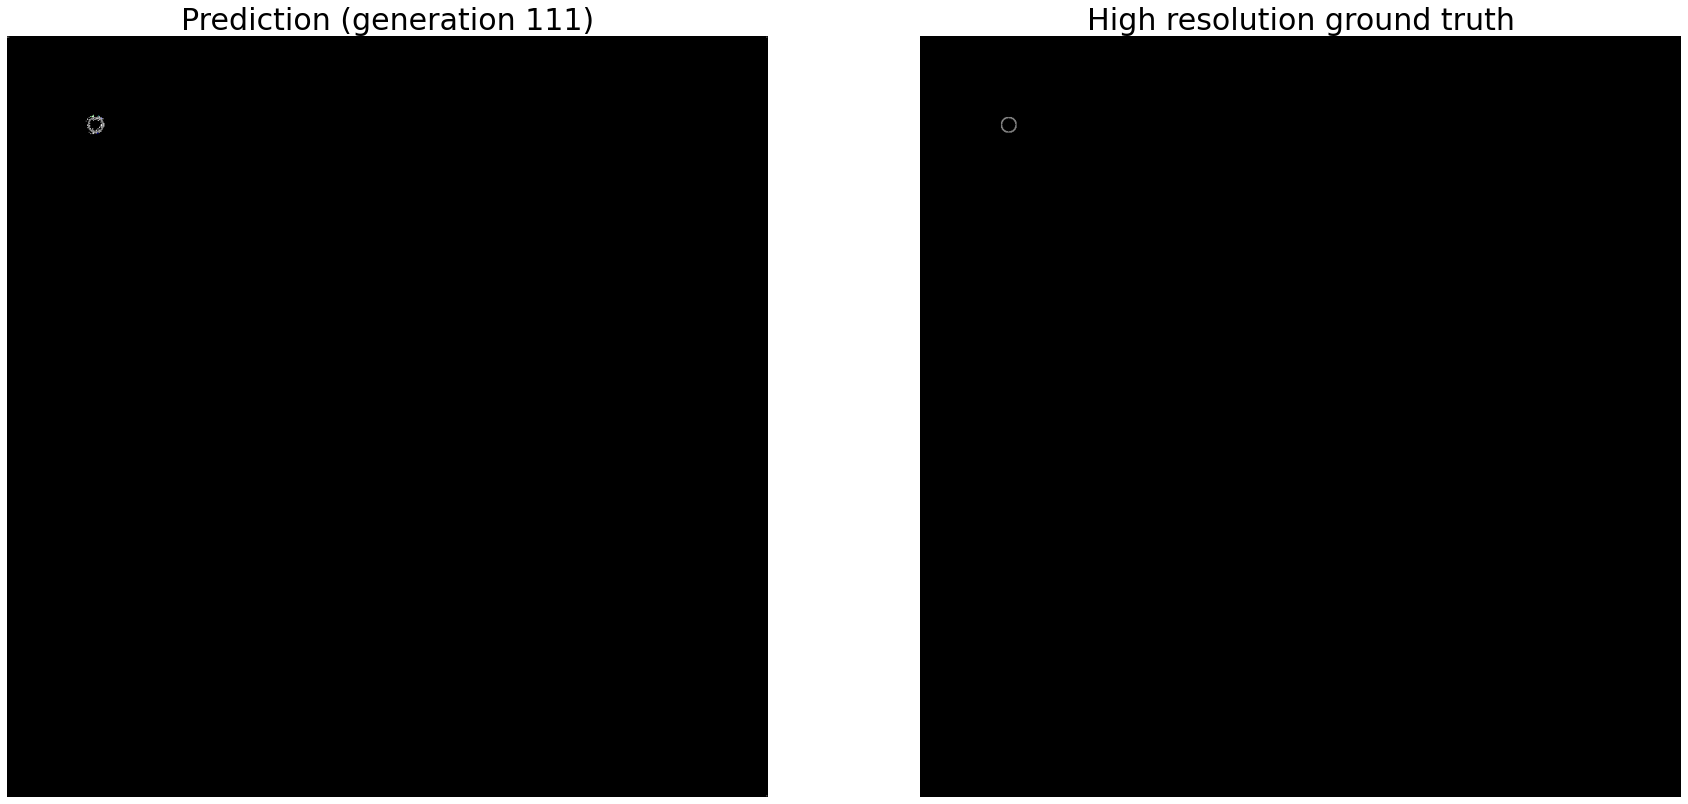

===> Epoch 111 Complete: Avg. Loss: 0.0407
===> Avg. PSNR: 48.0581 dB
===> Epoch 112 Complete: Avg. Loss: 0.0364
===> Avg. PSNR: 48.0576 dB
===> Epoch 113 Complete: Avg. Loss: 0.0353
===> Avg. PSNR: 48.2555 dB
===> Epoch 114 Complete: Avg. Loss: 0.0346
===> Avg. PSNR: 48.3384 dB
===> Epoch 115 Complete: Avg. Loss: 0.0343
===> Avg. PSNR: 48.2054 dB
===> Epoch 116 Complete: Avg. Loss: 0.0345
===> Avg. PSNR: 48.4261 dB
===> Epoch 117 Complete: Avg. Loss: 0.0351
===> Avg. PSNR: 47.2648 dB
===> Epoch 118 Complete: Avg. Loss: 0.0348
===> Avg. PSNR: 48.4475 dB
===> Epoch 119 Complete: Avg. Loss: 0.0332
===> Avg. PSNR: 48.6355 dB
===> Epoch 120 Complete: Avg. Loss: 0.0344
===> Avg. PSNR: 47.7055 dB


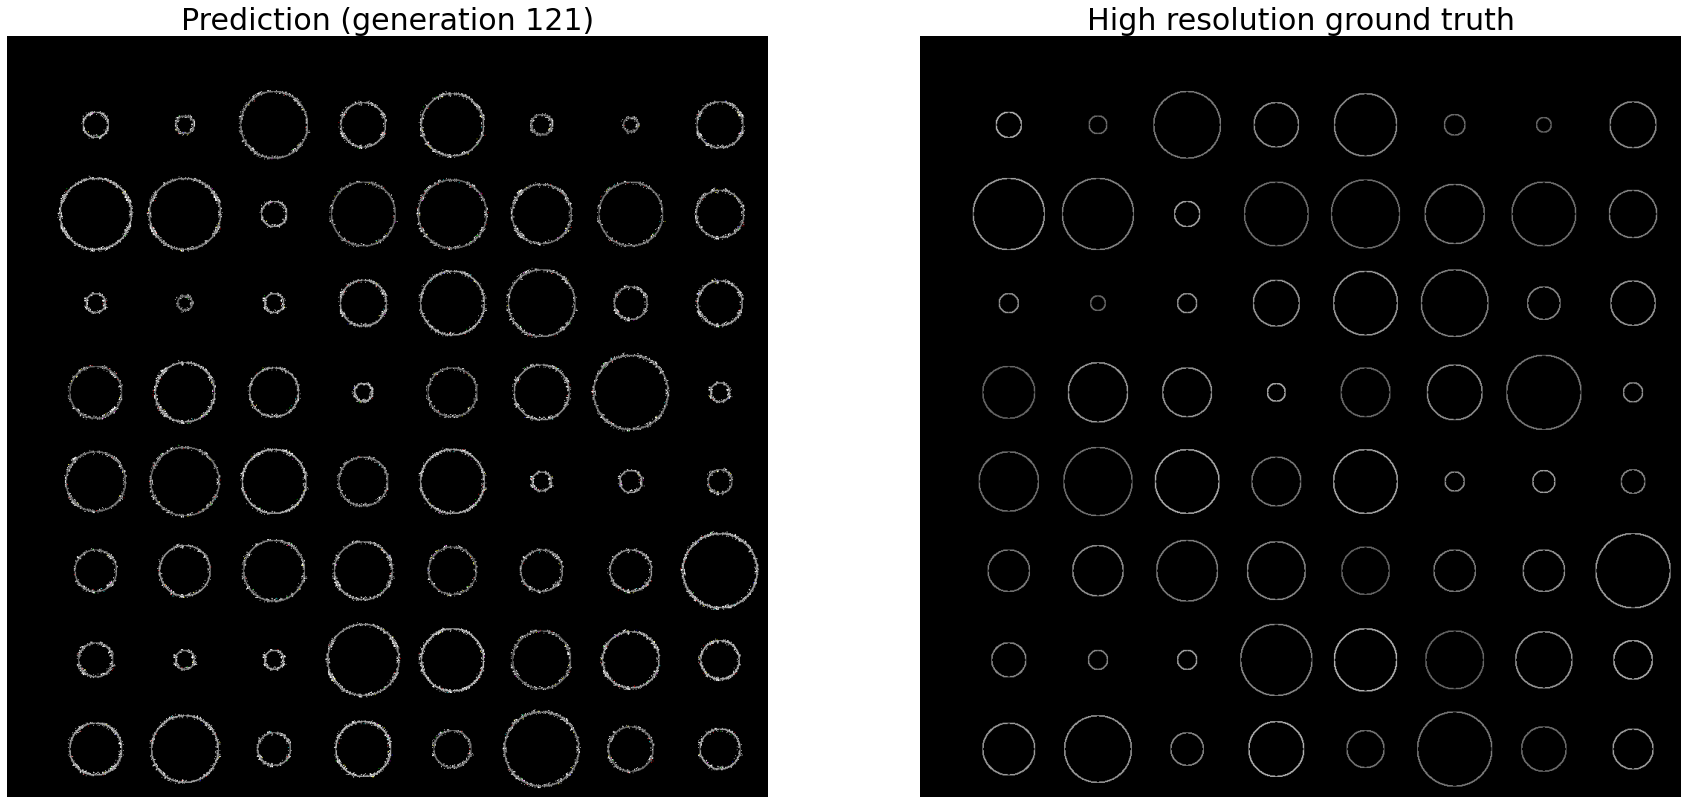

===> Epoch 121 Complete: Avg. Loss: 0.0340
===> Avg. PSNR: 48.3353 dB
===> Epoch 122 Complete: Avg. Loss: 0.0393
===> Avg. PSNR: 47.2797 dB
===> Epoch 123 Complete: Avg. Loss: 0.0389
===> Avg. PSNR: 47.9123 dB
===> Epoch 124 Complete: Avg. Loss: 0.0331
===> Avg. PSNR: 48.5561 dB
===> Epoch 125 Complete: Avg. Loss: 0.0327
===> Avg. PSNR: 48.6953 dB
===> Epoch 126 Complete: Avg. Loss: 0.0315
===> Avg. PSNR: 48.6783 dB
===> Epoch 127 Complete: Avg. Loss: 0.0325
===> Avg. PSNR: 48.1793 dB
===> Epoch 128 Complete: Avg. Loss: 0.0353
===> Avg. PSNR: 44.6892 dB
===> Epoch 129 Complete: Avg. Loss: 0.0384
===> Avg. PSNR: 46.9334 dB
===> Epoch 130 Complete: Avg. Loss: 0.0343
===> Avg. PSNR: 48.9439 dB


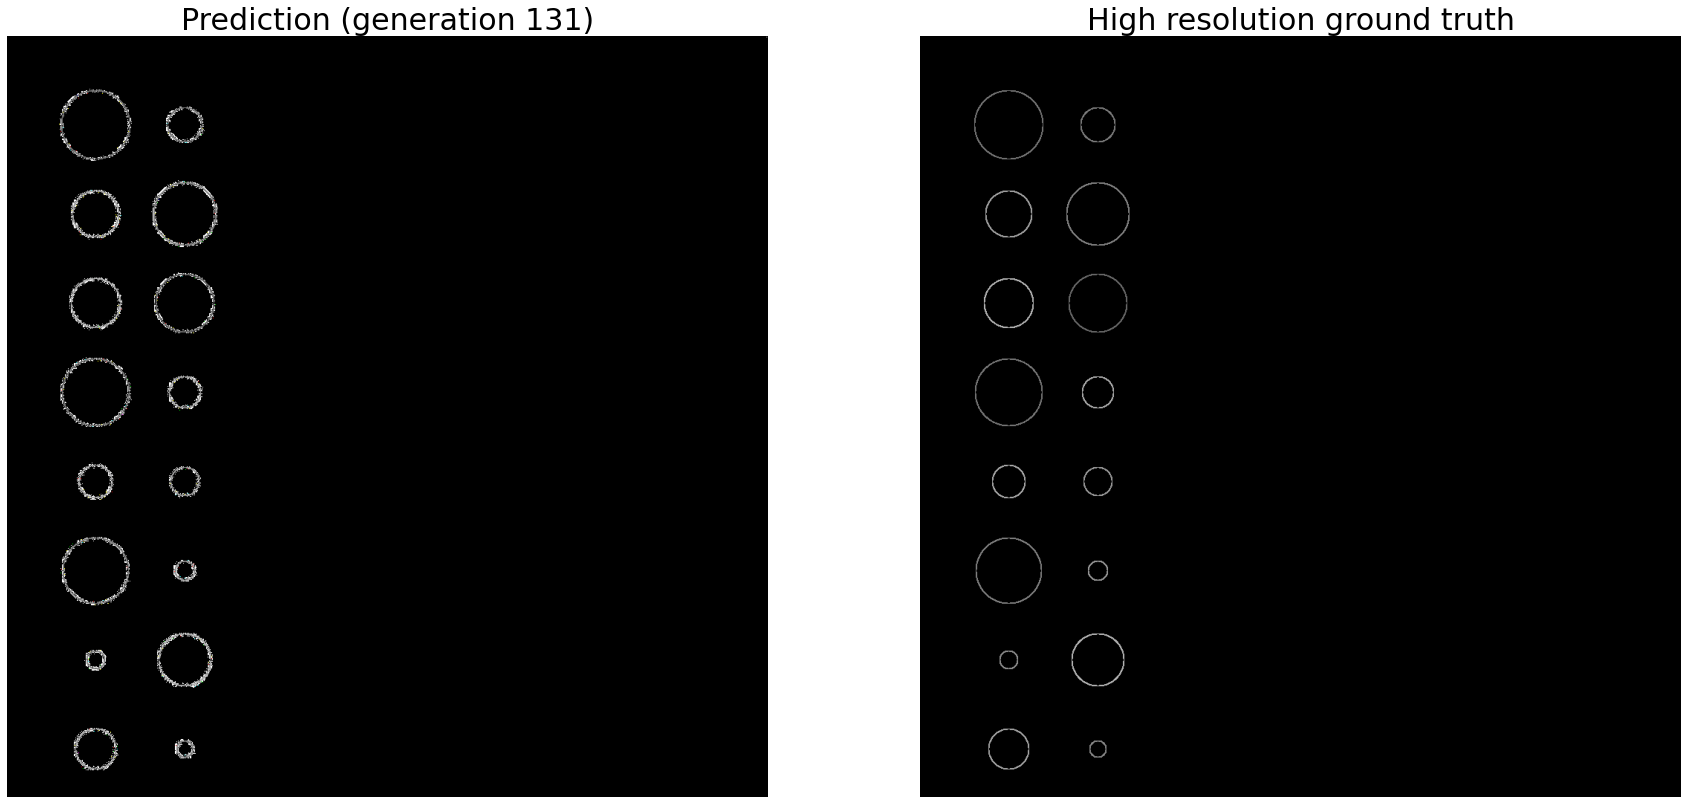

===> Epoch 131 Complete: Avg. Loss: 0.0306
===> Avg. PSNR: 48.8753 dB
===> Epoch 132 Complete: Avg. Loss: 0.0319
===> Avg. PSNR: 48.6074 dB
===> Epoch 133 Complete: Avg. Loss: 0.0316
===> Avg. PSNR: 48.7393 dB
===> Epoch 134 Complete: Avg. Loss: 0.0318
===> Avg. PSNR: 48.8456 dB
===> Epoch 135 Complete: Avg. Loss: 0.0333
===> Avg. PSNR: 48.2138 dB
===> Epoch 136 Complete: Avg. Loss: 0.0360
===> Avg. PSNR: 46.8520 dB
===> Epoch 137 Complete: Avg. Loss: 0.0624
===> Avg. PSNR: 47.2771 dB
===> Epoch 138 Complete: Avg. Loss: 0.0481
===> Avg. PSNR: 48.3418 dB
===> Epoch 139 Complete: Avg. Loss: 0.0308
===> Avg. PSNR: 49.0550 dB
===> Epoch 140 Complete: Avg. Loss: 0.0300
===> Avg. PSNR: 49.0226 dB


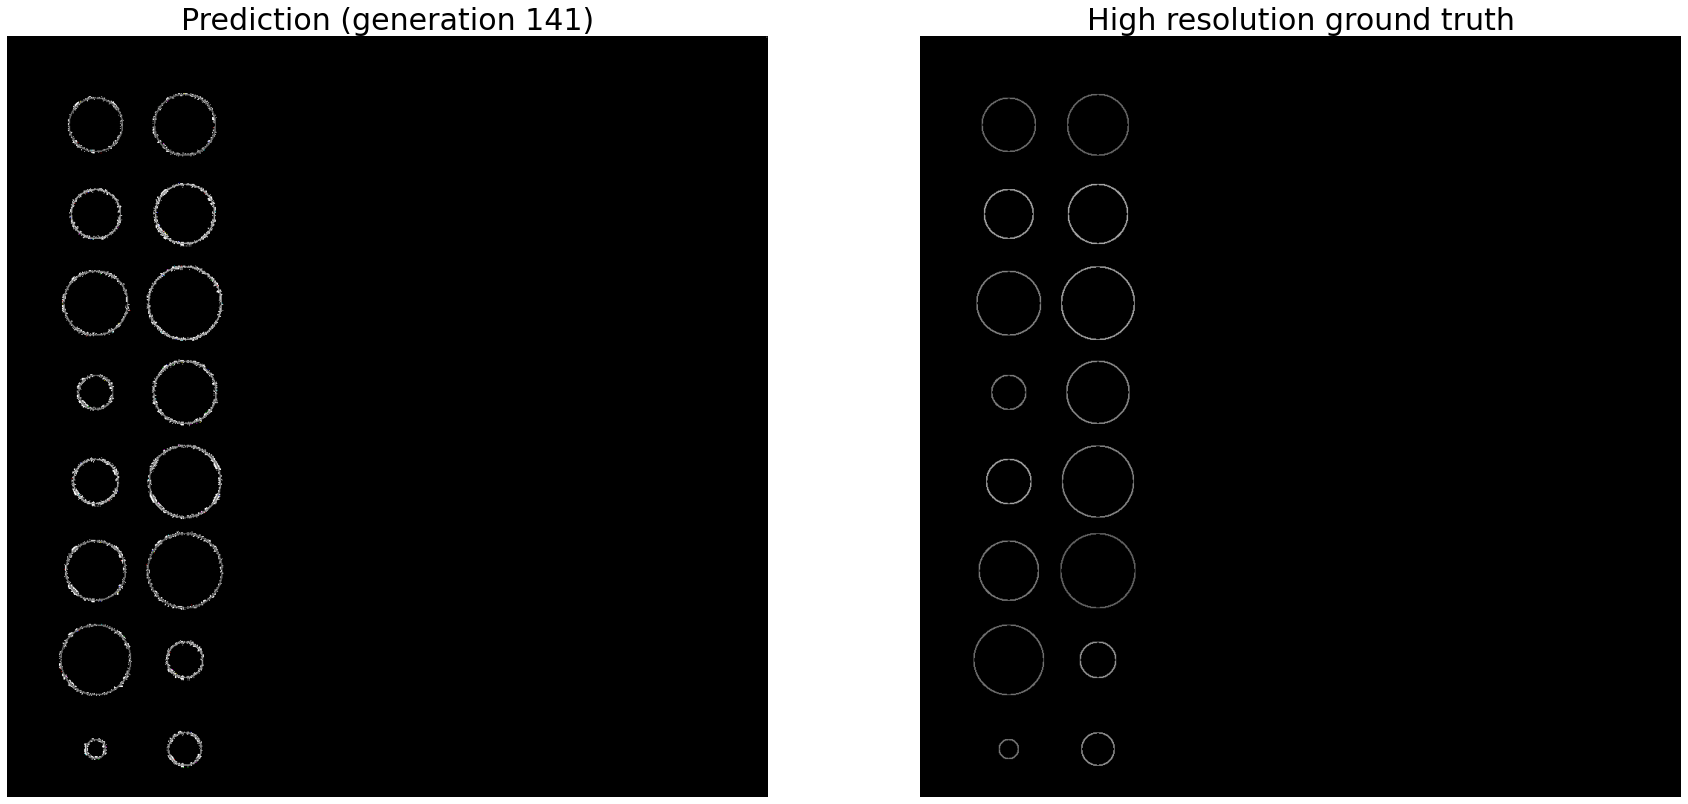

===> Epoch 141 Complete: Avg. Loss: 0.0302
===> Avg. PSNR: 49.2744 dB
===> Epoch 142 Complete: Avg. Loss: 0.0286
===> Avg. PSNR: 49.4135 dB
===> Epoch 143 Complete: Avg. Loss: 0.0282
===> Avg. PSNR: 49.4886 dB
===> Epoch 144 Complete: Avg. Loss: 0.0282
===> Avg. PSNR: 49.2398 dB
===> Epoch 145 Complete: Avg. Loss: 0.0278
===> Avg. PSNR: 49.5536 dB
===> Epoch 146 Complete: Avg. Loss: 0.0278
===> Avg. PSNR: 49.4367 dB
===> Epoch 147 Complete: Avg. Loss: 0.0298
===> Avg. PSNR: 48.9236 dB
===> Epoch 148 Complete: Avg. Loss: 0.0277
===> Avg. PSNR: 49.1588 dB
===> Epoch 149 Complete: Avg. Loss: 0.0345
===> Avg. PSNR: 48.6673 dB
===> Epoch 150 Complete: Avg. Loss: 0.0295
===> Avg. PSNR: 49.4842 dB


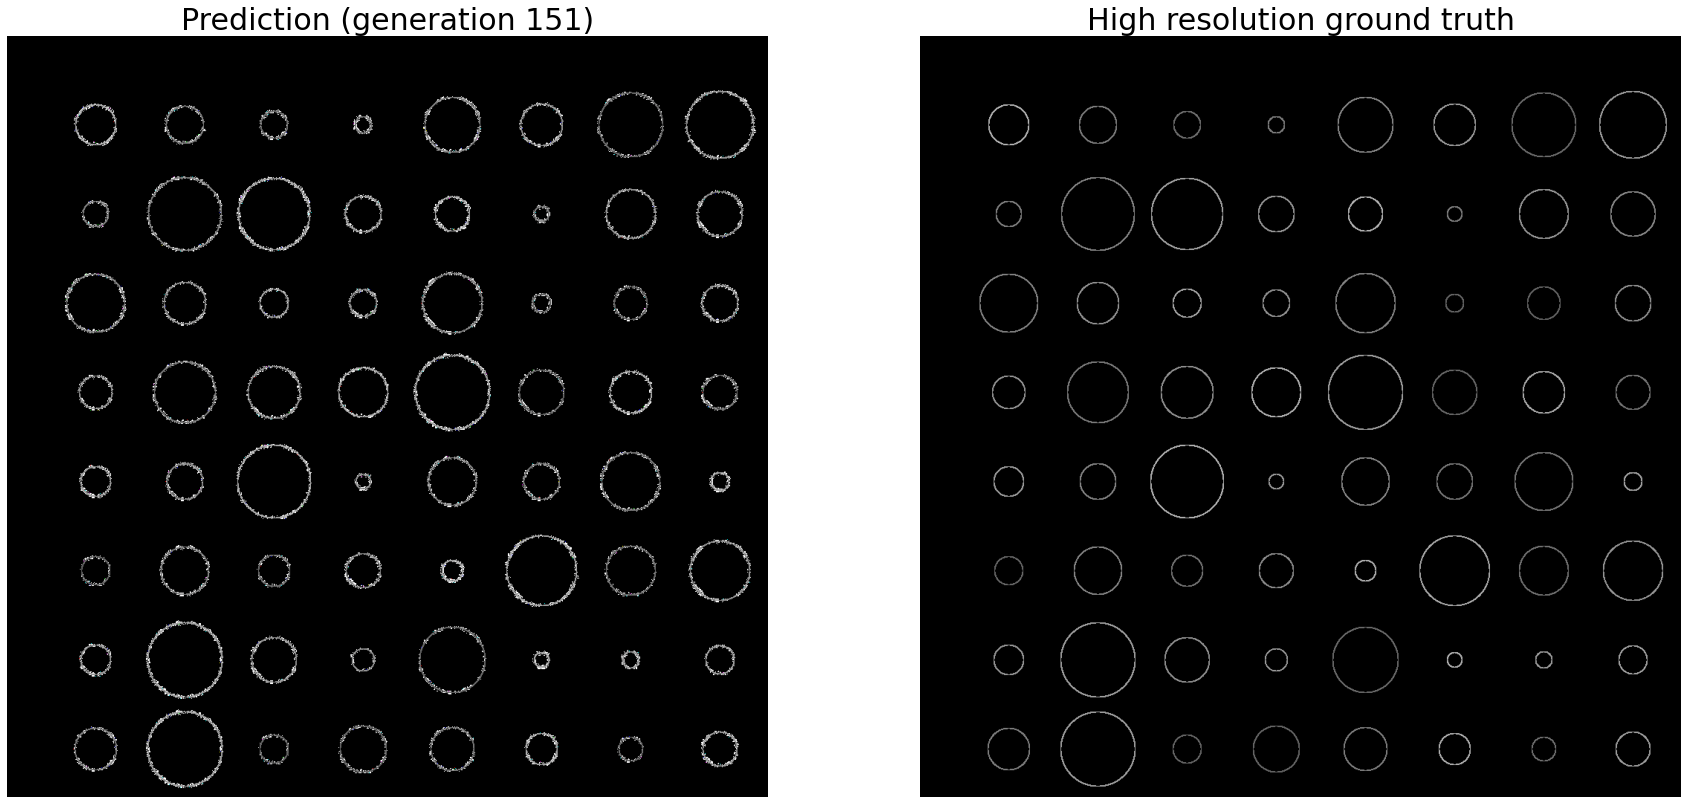

===> Epoch 151 Complete: Avg. Loss: 0.0270
===> Avg. PSNR: 49.6953 dB
===> Epoch 152 Complete: Avg. Loss: 0.0268
===> Avg. PSNR: 49.6760 dB
===> Epoch 153 Complete: Avg. Loss: 0.0272
===> Avg. PSNR: 49.3315 dB
===> Epoch 154 Complete: Avg. Loss: 0.0274
===> Avg. PSNR: 49.7105 dB
===> Epoch 155 Complete: Avg. Loss: 0.0340
===> Avg. PSNR: 45.4535 dB
===> Epoch 156 Complete: Avg. Loss: 0.0341
===> Avg. PSNR: 48.8278 dB
===> Epoch 157 Complete: Avg. Loss: 0.0279
===> Avg. PSNR: 49.6515 dB
===> Epoch 158 Complete: Avg. Loss: 0.0267
===> Avg. PSNR: 49.5371 dB
===> Epoch 159 Complete: Avg. Loss: 0.0305
===> Avg. PSNR: 49.1308 dB
===> Epoch 160 Complete: Avg. Loss: 0.0310
===> Avg. PSNR: 47.5845 dB


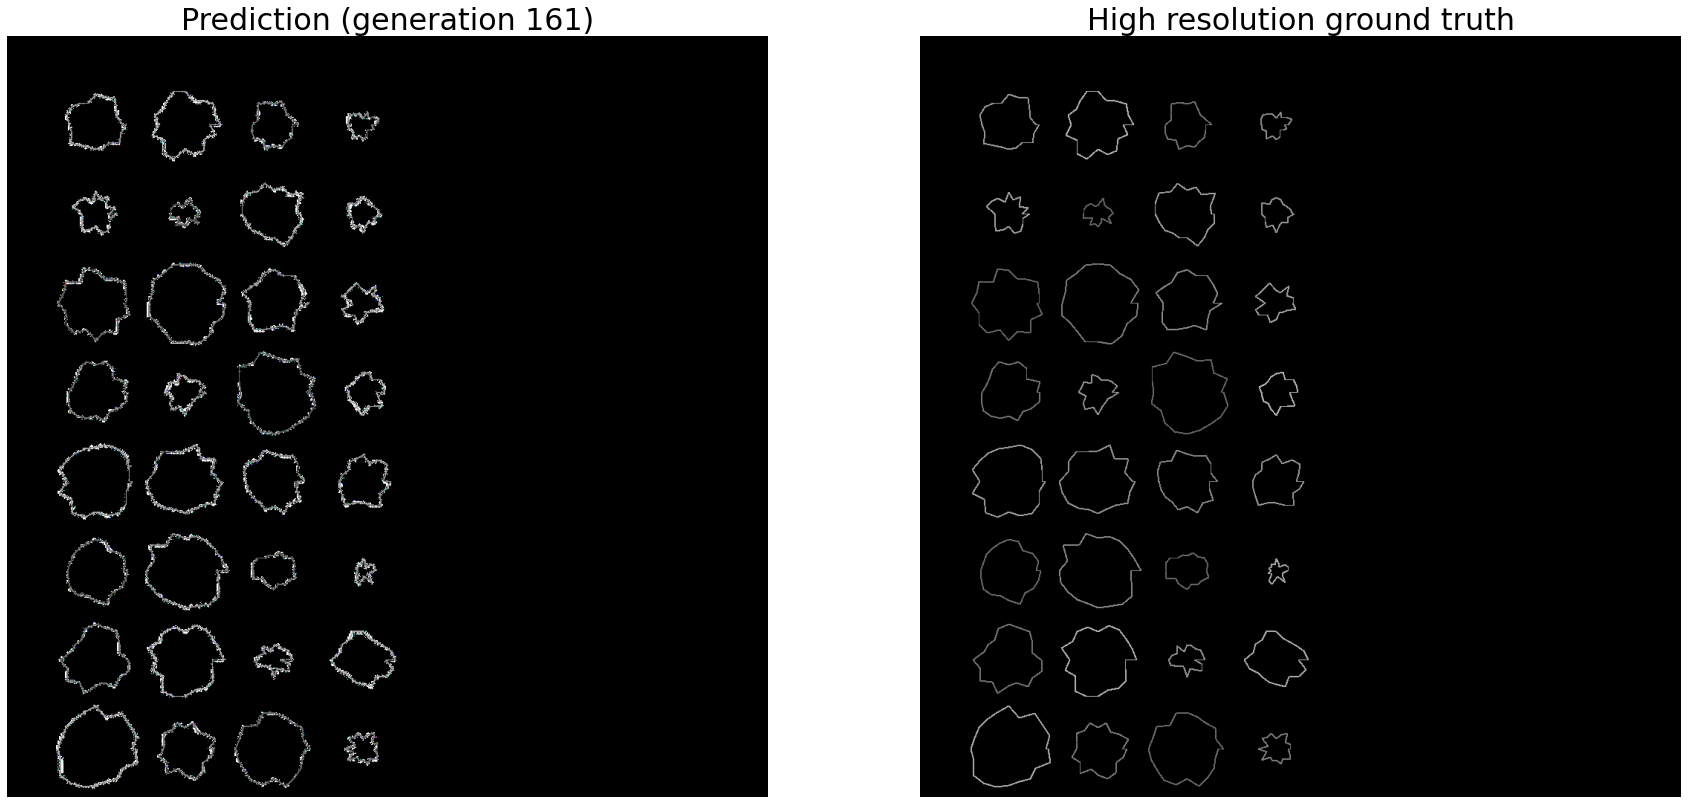

===> Epoch 161 Complete: Avg. Loss: 0.0309
===> Avg. PSNR: 49.3670 dB
===> Epoch 162 Complete: Avg. Loss: 0.0269
===> Avg. PSNR: 49.4855 dB
===> Epoch 163 Complete: Avg. Loss: 0.0260
===> Avg. PSNR: 48.6657 dB
===> Epoch 164 Complete: Avg. Loss: 0.0289
===> Avg. PSNR: 49.6861 dB
===> Epoch 165 Complete: Avg. Loss: 0.0252
===> Avg. PSNR: 50.2270 dB
===> Epoch 166 Complete: Avg. Loss: 0.0250
===> Avg. PSNR: 50.0748 dB
===> Epoch 167 Complete: Avg. Loss: 0.0342
===> Avg. PSNR: 49.4346 dB
===> Epoch 168 Complete: Avg. Loss: 0.0371
===> Avg. PSNR: 48.7246 dB
===> Epoch 169 Complete: Avg. Loss: 0.0293
===> Avg. PSNR: 49.4153 dB
===> Epoch 170 Complete: Avg. Loss: 0.0256
===> Avg. PSNR: 49.9368 dB


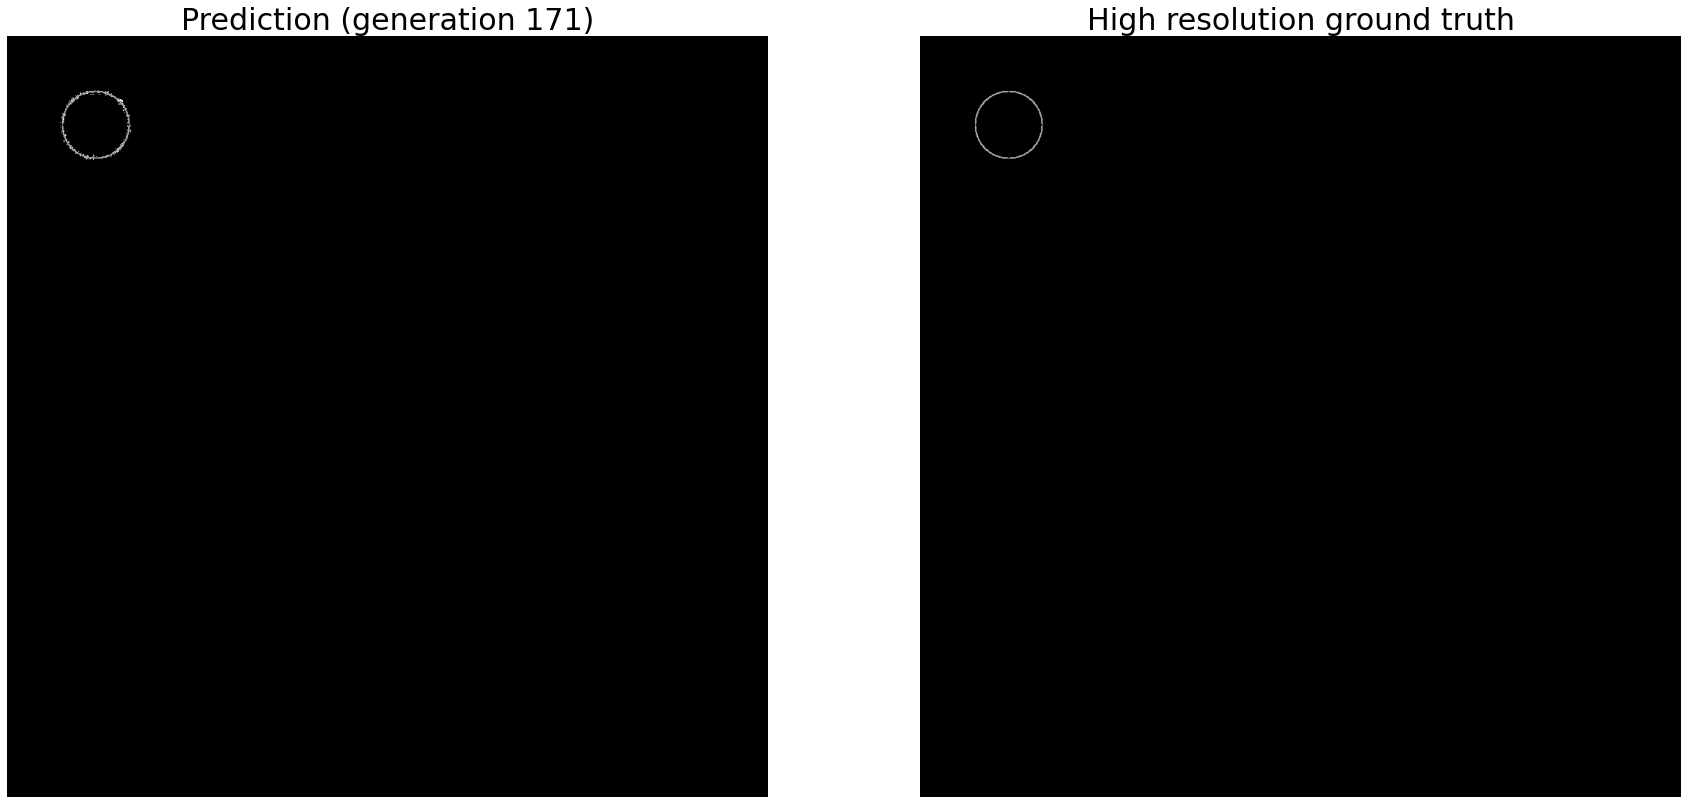

===> Epoch 171 Complete: Avg. Loss: 0.0255
===> Avg. PSNR: 50.2309 dB
===> Epoch 172 Complete: Avg. Loss: 0.0246
===> Avg. PSNR: 50.1328 dB
===> Epoch 173 Complete: Avg. Loss: 0.0255
===> Avg. PSNR: 49.6290 dB
===> Epoch 174 Complete: Avg. Loss: 0.0284
===> Avg. PSNR: 50.0559 dB
===> Epoch 175 Complete: Avg. Loss: 0.0258
===> Avg. PSNR: 48.9348 dB
===> Epoch 176 Complete: Avg. Loss: 0.0252
===> Avg. PSNR: 50.2984 dB
===> Epoch 177 Complete: Avg. Loss: 0.0267
===> Avg. PSNR: 48.5545 dB
===> Epoch 178 Complete: Avg. Loss: 0.0459
===> Avg. PSNR: 47.2756 dB
===> Epoch 179 Complete: Avg. Loss: 0.0264
===> Avg. PSNR: 50.0591 dB
===> Epoch 180 Complete: Avg. Loss: 0.0236
===> Avg. PSNR: 50.1153 dB


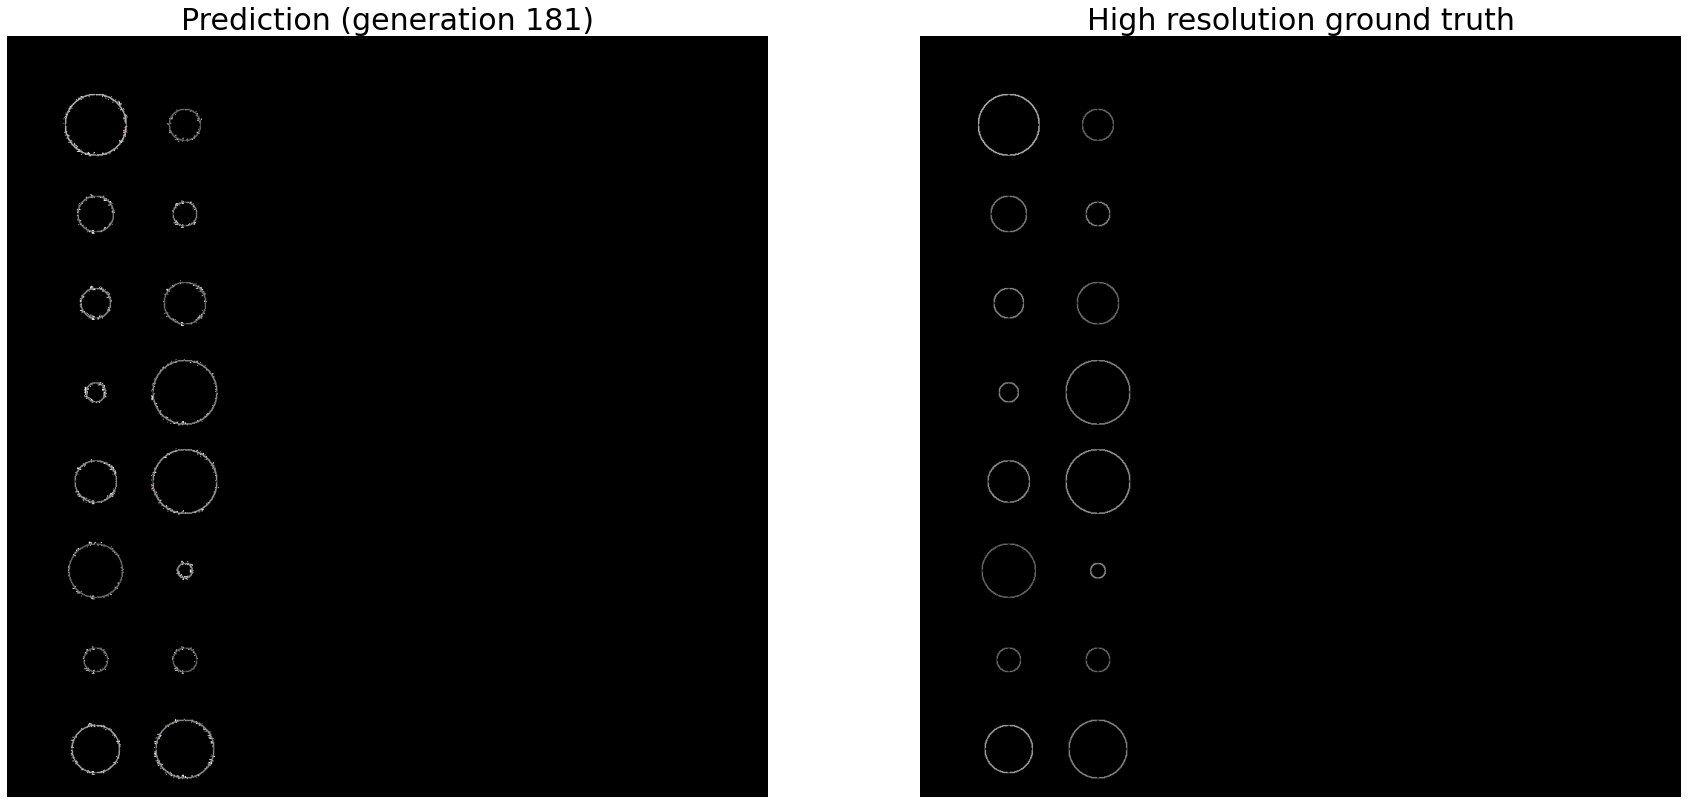

===> Epoch 181 Complete: Avg. Loss: 0.0241
===> Avg. PSNR: 50.0480 dB
===> Epoch 182 Complete: Avg. Loss: 0.0267
===> Avg. PSNR: 45.6174 dB
===> Epoch 183 Complete: Avg. Loss: 0.0273
===> Avg. PSNR: 49.4111 dB
===> Epoch 184 Complete: Avg. Loss: 0.0244
===> Avg. PSNR: 50.1984 dB
===> Epoch 185 Complete: Avg. Loss: 0.0239
===> Avg. PSNR: 50.1948 dB
===> Epoch 186 Complete: Avg. Loss: 0.0230
===> Avg. PSNR: 50.3161 dB
===> Epoch 187 Complete: Avg. Loss: 0.0249
===> Avg. PSNR: 50.3675 dB
===> Epoch 188 Complete: Avg. Loss: 0.0257
===> Avg. PSNR: 50.3421 dB
===> Epoch 189 Complete: Avg. Loss: 0.0239
===> Avg. PSNR: 48.8356 dB
===> Epoch 190 Complete: Avg. Loss: 0.0244
===> Avg. PSNR: 50.6695 dB


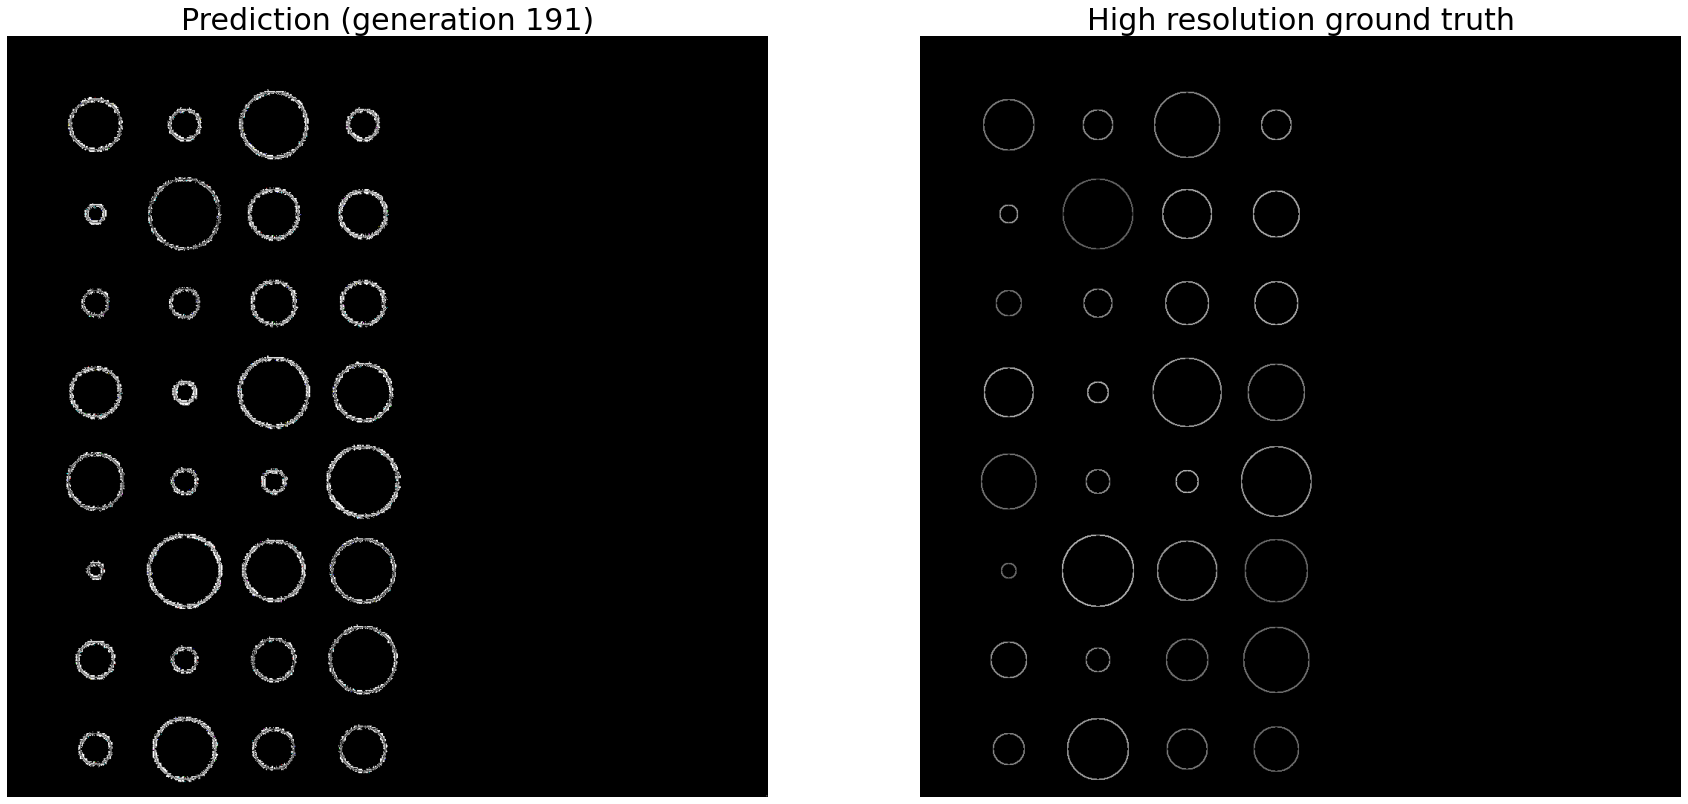

===> Epoch 191 Complete: Avg. Loss: 0.0291
===> Avg. PSNR: 48.8035 dB
===> Epoch 192 Complete: Avg. Loss: 0.0313
===> Avg. PSNR: 48.1395 dB
===> Epoch 193 Complete: Avg. Loss: 0.0251
===> Avg. PSNR: 50.2763 dB
===> Epoch 194 Complete: Avg. Loss: 0.0228
===> Avg. PSNR: 50.3728 dB
===> Epoch 195 Complete: Avg. Loss: 0.0263
===> Avg. PSNR: 46.6235 dB
===> Epoch 196 Complete: Avg. Loss: 0.0299
===> Avg. PSNR: 50.3325 dB
===> Epoch 197 Complete: Avg. Loss: 0.0220
===> Avg. PSNR: 50.3974 dB
===> Epoch 198 Complete: Avg. Loss: 0.0227
===> Avg. PSNR: 49.1210 dB
===> Epoch 199 Complete: Avg. Loss: 0.0272
===> Avg. PSNR: 50.1911 dB


In [10]:

l = []

def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(train_loader, 1):
        input_, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        pred = model(input_)
        loss = criterion(pred, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        print("===> Epoch[{}]({}/{})".format(epoch, iteration, len(train_loader)), end="\r")

    if epoch % 10 == 1:
      compare(pred[0], target[0], epoch)
    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, 1000*epoch_loss / len(train_loader)))
    l.append(1000*epoch_loss / len(train_loader))


def test():
    avg_psnr = 0
    with torch.no_grad():
        for batch in test_loader:
            input_, target = batch[0].to(device), batch[1].to(device)
            prediction = model(input_)
            mse = criterion(prediction, target)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr

    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(test_loader)))



for epoch in range(1, 200):
    train(epoch)
    test()


In [13]:
#save = input("Overwrite current state dictionnary ? [y/n]")
save = 'y'
if (save == 'y'): 
  torch.save(model.state_dict(), 'drive/My Drive/Super Resolution/model_50dB.pth')
  print("State dictionnary saved.")
else: 
  print("State dictionnary has not been saved.")

State dictionnary saved.
